In [1]:
##### notebook for BraidedSP generation over braided channels 

In [2]:
# ------------------------------ IMPORT LIBRARIES ------------------------------

import geopandas as gpd
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import sys
sys.path.append("/Volumes/OneTouch/work/scripts")
import procBraided as pc
import skeletonize_func as skel
from shapely.geometry import LineString, Point
from skimage.morphology import label, binary_dilation

# RiverSP processing
from shapely.geometry import MultiPoint, shape
import shapely

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Transient functions

# import rasterio
# from rasterio.transform import rowcol

def calculate_vector_general(coord1, coord2):
    # Calculate the direction vector for a LineString at the given endpoint.
    vec = np.array(coord2) - np.array(coord1)
    return vec / np.linalg.norm(vec)  # Normalize

# Function from stack exchange: https://gis.stackexchange.com/questions/177583/interpolating-every-x-distance-along-line-in-shapely
def create_points(row, point_separation):
    # Can be used for many different linestrings!
    geom = row.geometry
    #For each geometry, create a point along it for each distance in the range from 0 to line length, with an interval
    point_list = [geom.interpolate(distance=x) for x in np.arange(start=0, stop=geom.length, step=point_separation)]
    return point_list


def trim_to_one_channel(sel_cl_gdf, swot_gdf,hemi,tile_figdir,pixcdate,channelID,buffer_width=1000,savePlot=False):

    # Buffer around channel (= 1000 unless known riv width passed in)
    gdf_buffered = pc.get_width_dependent_buffer(sel_cl_gdf,'EPSG:4326',hemi,buffer_width,cap_val='flat')

    # Trim SWOT PIXC to buffer
    clipped_gdf = gpd.clip(swot_gdf, gdf_buffered) # Use 'trimmed_gdf' to use water mask trimmed data
    clipped_gdf = clipped_gdf.copy()

    if len(clipped_gdf) > 0:

        # project SWOT PIXC to channel centerline
        clipped_gdf['dist'] = pc.projectToCenterline(sel_cl_gdf,clipped_gdf[['geometry']],hemi)
        clipped_gdf['channelID'] = int(sel_cl_gdf.branch_id)

    if savePlot==True and len(clipped_gdf) > 0:
        fig, ax = plt.subplots(figsize=(10, 10))
        swot_gdf.plot(ax=ax, color='purple',markersize=0.1)
        clipped_gdf.plot(ax=ax, color='yellow',markersize=0.1)
        sel_cl_gdf.plot(ax=ax, color='blue', label='Centerline', linewidth=0.5)
        gdf_buffered.plot(ax=ax, color='lightblue', alpha=0.5, label='Buffered Area')
        ax.set_title('Channel'+str(channelID)+', Buffer width:'+str(buffer_width),fontsize=15)
        # Remove x and y tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        plt.savefig(tile_figdir+str(pixcdate)+'_buffer_ch'+str(channelID)+'.png')
        #plt.savefig(figdir+'/'+tileID+'/generated_nodes/'+str(pixcdate)+'_genNodes_ch'+str(channelID)+'.png')
        plt.close()

    return clipped_gdf


def get_RiverSP(trimmed_pixc_gdf,cl_gen,hemi,season,pixcdate,tileID,figdir,odir,buffer_conv=50):

    # Function for extracting a 'riverSP' product over all branches of the river centerline
    # For rotating the buffer
    theta = np.radians(90)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c))) #2D rotation matrix

    riverSP_gdf = gpd.GeoDataFrame() # initialize dataframe
    iter_max = 5

    for channelID in cl_gen.branch_id:
    #for channelID in [21,26]:
        print('Running channel...',channelID)

        swot_break = False

        #print('.......running width extraction for ch. ',channelID)
        # Select channel
        sel_channel = cl_gen.loc[cl_gen.branch_id == channelID]

        # convert to UTM
        centroid = sel_channel.geometry.unary_union.centroid
        utm_zone = int((centroid.x + 180) // 6) + 1
        if hemi == 'north':
            utm_crs = f'EPSG:{32600 + utm_zone}'
        elif hemi == 'south':
            utm_crs = f'EPSG:{32700 + utm_zone}'
        else:
            raise ValueError("Invalid hemisphere. Use 'north' or 'south'.")

        sel_channel_utm = sel_channel.to_crs(utm_crs)
        coords_list = list(sel_channel_utm.geometry.iloc[0].coords)
        x_coords = [x for x,y in coords_list]
        y_coords = [y for x,y in coords_list]

        # extract point locations every 100 m along the line
        sel_channel_utm["point_list"] = sel_channel_utm.apply(lambda x: create_points(row=x, point_separation=200), axis=1)

        #Create a point dataframe by exploding the point list into individual points/rows
        points_df = sel_channel_utm.explode(column="point_list")
        points_df = points_df.set_geometry("point_list").drop(columns="geometry").rename_geometry("geometry").set_crs(sel_channel_utm.crs)
        points_df = points_df.reset_index(drop=True)

        if len(points_df) <= 1:
            print('Channel contains only one point....skipping channel No. ',channelID)
            continue

        # Extract data from SWOT PIXC based on large manual buffer (larger than any expected channel width)
        # Buffer width and transect length dependant on maximum expected channel width (knowledge from visual inspection of S2 masks) for each season
        if season == 'LF':
            init_buffer_width = 2000
            transect_len = 2000
        else:
            init_buffer_width = 3000
            transect_len = 3000

        buffer_width_prev = init_buffer_width*100 # set large previous buffer width to begin with
        buffer_width = init_buffer_width

        iter = 1
        while abs(buffer_width - buffer_width_prev) > buffer_conv and swot_break == False and iter <= iter_max: # condition for buffer width convergence

            #print('Updating buffer width:',buffer_width)

            #print('Extracting SWOT data within channel buffer...')
            tile_figdir = figdir+'/'+tileID+'/generated_nodes/'
            sub_swot = trim_to_one_channel(sel_channel, trimmed_pixc_gdf,hemi,tile_figdir,pixcdate,channelID,buffer_width=buffer_width,savePlot=True) # Extracts SWOT data for one channel
            sub_swot_utm = sub_swot.to_crs(utm_crs)

            # if sub_swot contains no data...break and continue
            if len(sub_swot.heightEGM) <= 1:
                swot_break = True
                continue

            # Give each PIXC cloud point a point geometry
            mpt = MultiPoint([shape(row['geometry']) for _, row in sub_swot_utm.iterrows()])

            ratioval = 0.01
            if float(sel_channel_utm.geometry.length) > 3000: # change ratio value for SWOT extent polygon determination based on selected channel reach length
                ratioval = 0.05

            shapeout = shapely.concave_hull(mpt, ratio=ratioval,allow_holes=True)
            swot_boundary = gpd.GeoDataFrame(geometry=[shapeout],crs=utm_crs)

            # save transects to a gdf for plotting
            transects_gdf = gpd.GeoDataFrame() # initialize dataframe
            intersects_gdf = gpd.GeoDataFrame() # initialize dataframe
            extract_polys = gpd.GeoDataFrame() # initialize dataframe
            riverSP_gdf_oneChannel = gpd.GeoDataFrame() # initialize dataframe for saving single channels


            #print('Extracting transects, widths and heights...')
            for idx in points_df.index:
                coord = list(points_df.geometry.iloc[idx].coords)
                if idx == 0:
                    coord_b4 = coord
                    coord_af = list(points_df.geometry.iloc[idx+1].coords)

                if idx == len(points_df.index) - 1:
                    coord_b4 = list(points_df.geometry.iloc[idx-1].coords)
                    coord_af = coord


                if idx != len(points_df.index) - 1 and idx != 0:
                    coord_b4 = list(points_df.geometry.iloc[idx-1].coords)
                    coord_af = list(points_df.geometry.iloc[idx+1].coords)

                coord_b4 = [coord_b4[0][0],coord_b4[0][1]]
                coord_af = [coord_af[0][0],coord_af[0][1]]

                # Compute vector and rotated vector
                vec = calculate_vector_general(coord_b4,coord_af)
                rot_vec = np.dot(vec, R)

                pt1 = np.array(coord) - transect_len*rot_vec
                pt2 = np.array(coord) + transect_len*rot_vec
                line = LineString([Point(pt1),Point(pt2)])

                # plot transect
                transect_temp = gpd.GeoDataFrame(geometry=[line],crs=points_df.crs)
                transects_gdf = pd.concat([transects_gdf,transect_temp])

                # Find intersection line with swot polygon
                inter_geom = shapely.intersection(swot_boundary,transect_temp)
                intersects_gdf = pd.concat([intersects_gdf,inter_geom])
                
                # Extract 100 m buffer poly around line (for med H estimation)
                extract_poly = inter_geom.geometry.iloc[0].buffer(100,cap_style="flat")
                extract_poly_gdf = gpd.GeoDataFrame(geometry=[extract_poly],crs=utm_crs)
                extract_polys = pd.concat([extract_polys,extract_poly_gdf])

                sub_swot_utm['inPoly']=extract_poly_gdf.geometry.iloc[0].contains(sub_swot_utm.geometry)
                subset = sub_swot_utm[sub_swot_utm['inPoly']==True]

                lineW =inter_geom.geometry.length

                # Compute median if data exists within subset
                if len(subset) > 0:
                    medH = np.nanmedian(subset.heightEGM)
                    medH_ell = np.nanmedian(subset.height)
                    medGeoid = np.nanmedian(subset.geoid)
                    med_water_frac = np.nanmedian(subset.water_frac)
                    med_phstd = np.nanmedian(subset.phase_noise_std)
                    med_dhdp = np.nanmedian(subset.dheight_dphase)
                    med_sig0 = np.nanmedian(subset.sig0) # changed these to nanmedian
                else:
                    medH = np.nan
                    medH_ell = np.nan
                    medGeoid = np.nan
                    med_water_frac = np.nan
                    med_phstd = np.nan
                    med_dhdp = np.nan
                    med_sig0 = np.nan

                # get line width 

                
                # print('median H:',medH)
                # print('width:',lineW)

                # Save to RiverSP GDF with point geometry
                riverSP_temp = gpd.GeoDataFrame(geometry=[Point(coord)],crs=utm_crs)
                riverSP_temp['heightEGM_med'] = medH
                riverSP_temp['width'] = lineW
                riverSP_temp['channelID'] = channelID
                nodeID = str(channelID) + str(idx)
                riverSP_temp['nodeID'] = nodeID
                riverSP_temp['heightEll_med'] = medH_ell
                riverSP_temp['geoid_med'] = medGeoid
                riverSP_temp['wf_med'] = med_water_frac
                riverSP_temp['phstd_med'] = med_phstd
                riverSP_temp['dhdp_med'] = med_dhdp
                riverSP_temp['sig0_med'] = med_sig0

                riverSP_gdf_oneChannel = pd.concat([riverSP_gdf_oneChannel,riverSP_temp])
            
            iter = iter + 1

            # Update buffer width condition
            medW = np.median(riverSP_gdf_oneChannel.width)
            buffer_width_prev = buffer_width
            buffer_width = np.round(medW*1.1) # buffer with 10% extra of the median width
            #print('Median width of channel:',medW)


        if iter == iter_max:
            print('Buffer width not converged, max iteration reached.')
            

        if swot_break == True:
            print('No SWOT data around channel...skipping channel: ',channelID)
            continue
        
        #print('Final channel width:',medW)
        #print('Final buffer width:',buffer_width_prev)
        riverSP_gdf = pd.concat([riverSP_gdf,riverSP_gdf_oneChannel])


        # Plot selected channel centerline, extracted points, and transects for each channel
        ax = sel_channel_utm.plot(figsize=(5,5))
        points_df.plot(ax=ax, zorder=2, color="black", markersize=50, marker=".")
        transects_gdf.plot(ax=ax, zorder=2, color="red")
        intersects_gdf.plot(ax=ax, zorder=2, color="yellow")
        sub_swot_utm.plot(ax=ax, column='heightEGM', markersize=0.1, legend=True,cmap='Spectral')
        extract_polys.plot(ax=ax, zorder=2,color='blue',alpha=0.4)
        ax.set_title('Ch. '+str(channelID))
        # Remove x and y tick marks
        ax.set_xticks([])
        ax.set_yticks([])


        isExist = os.path.exists(figdir+'/'+tileID+'/generated_nodes/')
        if not isExist:
            os.makedirs(figdir+'/'+tileID+'/generated_nodes/')
        plt.savefig(figdir+'/'+tileID+'/generated_nodes/'+str(pixcdate)+'_genNodes_ch'+str(channelID)+'.png')
        plt.close()

        # Save also the swot generated polygon
        ax = sel_channel_utm.plot(figsize=(5,5))
        swot_boundary.plot(ax=ax)
        points_df.plot(ax=ax, zorder=2, color="black", markersize=50, marker=".")
        transects_gdf.plot(ax=ax, zorder=2, color="red")
        intersects_gdf.plot(ax=ax, zorder=2, color="yellow")
        ax.set_title('Ch. '+str(channelID))
        # Remove x and y tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        plt.savefig(figdir+'/'+tileID+'/generated_nodes/'+str(pixcdate)+'_SWOTBOUNDARY_ch'+str(channelID)+'.png')
        plt.close()

        # print('RiverSP for channel No. ',channelID)
        # print(riverSP_gdf.loc[riverSP_gdf.channelID == channelID])

        # Save the SWOT boundary (buffer) used here to extract PIXC data
        testfile = glob.glob(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_'+str(channelID)+'_subswot.geojson')
        if not testfile:    
            print('Saving boundary of selected SWOT data...')
            sub_swot.to_file(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_'+str(channelID)+'_subswot.geojson')
            print('SUCCESS!')


    return riverSP_gdf

In [5]:
# ------------------------------ STATICS ------------------------------

featureName = 'brahmaputra'
hemi='north'
datadir = "/Volumes/OneTouch/work/SWOTC/"+featureName+"/PIXC/"
wdir = "/Volumes/OneTouch/work/SWOTbraided/scripts/"
odir = datadir+"extracted/"
figdir = "/Volumes/OneTouch/work/SWOTbraided/figs/"+featureName
cldir = glob.glob("/Volumes/OneTouch/work/SWORD/v16/"+featureName+"/*full*.shp")[0]
print(cldir)
isExist = os.path.exists(odir)
if not isExist:
    os.makedirs(odir)


LFmonths = [1,2,3,4,5,11,12]
HFmonths = [6,7,8,9,10]

/Volumes/OneTouch/work/SWORD/v16/brahmaputra/brahmaputra_full.shp


In [6]:
tileID = '258_112L'
pixc_filenames = glob.glob("/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/*"+tileID+"*") # Need to download 1 year of data for this tile! 
pixc_filenames

['/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_010_258_112L_20240203T045957_20240203T050008_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_018_258_112L_20240719T030033_20240719T030044_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_022_258_112L_20241010T140054_20241010T140105_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_021_258_112L_20240919T171548_20240919T171559_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_020_258_112L_20240829T203042_20240829T203053_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_019_258_112L_20240808T234537_20240808T234548_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_017_258_112L_20240628T061528_20240628T061539_PIC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_015_258_112L_20240517T124519_20240517T124530_PIC0_01.nc',
 '/Volumes/OneTouch/work

Runnning braided river analysis for: 20231001
Closest mask date: 1023


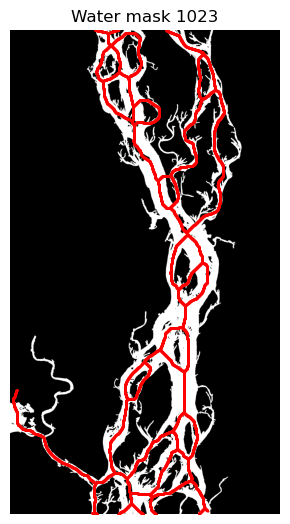

Reading in SWOT PIXC data...
No centerline buffer to trim to.
Trimming PIXC data to simplified water mask...
Running RiverSP processing for date... 20231001
Running channel... 1
No SWOT data around channel...skipping channel:  1
Running channel... 2
No SWOT data around channel...skipping channel:  2
Running channel... 3
Running channel... 4
Running channel... 5
Running channel... 6
Buffer width not converged, max iteration reached.
Running channel... 7
Running channel... 8
Running channel... 9
Running channel... 10
Running channel... 11
Buffer width not converged, max iteration reached.
Running channel... 12
Running channel... 13
Running channel... 14
Running channel... 15
Running channel... 16
Running channel... 17
Running channel... 18
Running channel... 19
Running channel... 20
Running channel... 21
Running channel... 22
Buffer width not converged, max iteration reached.
Running channel... 23
Running channel... 24
Running channel... 25
Running channel... 26
Running channel... 27
Run

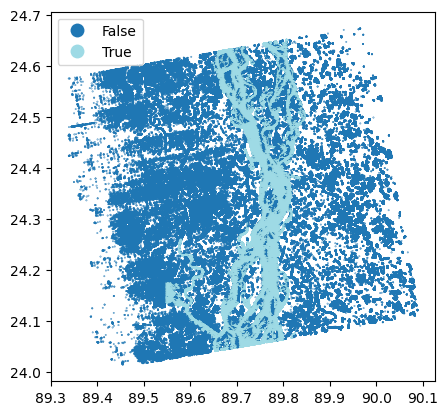

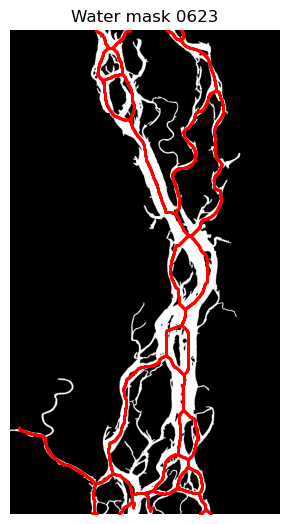

Reading in SWOT PIXC data...
No centerline buffer to trim to.
Trimming PIXC data to simplified water mask...
Running RiverSP processing for date... 20230730
Running channel... 1
No SWOT data around channel...skipping channel:  1
Running channel... 2
Running channel... 3
No SWOT data around channel...skipping channel:  3
Running channel... 4
Running channel... 5
No SWOT data around channel...skipping channel:  5
Running channel... 6
No SWOT data around channel...skipping channel:  6
Running channel... 7
Running channel... 8
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 9
Buffer width not converged, max iteration reached.
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 10
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 11
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 12
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 13
Saving boundary of selected SWOT data...
SUCCESS!
Running cha

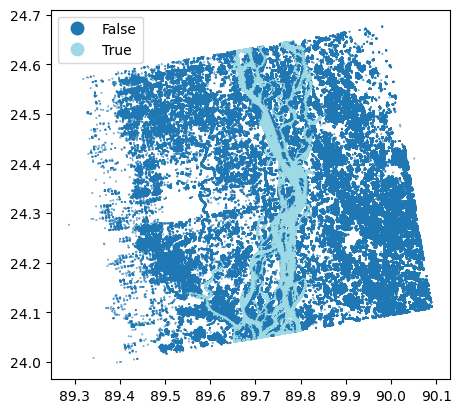

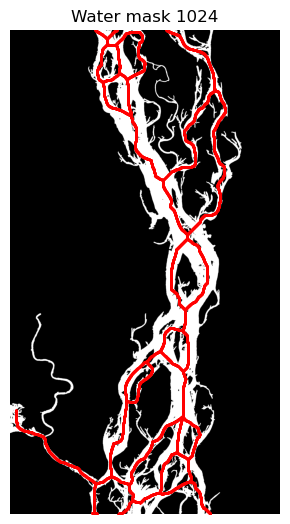

Reading in SWOT PIXC data...
No centerline buffer to trim to.
Trimming PIXC data to simplified water mask...
Running RiverSP processing for date... 20241031
Running channel... 1
No SWOT data around channel...skipping channel:  1
Running channel... 2
No SWOT data around channel...skipping channel:  2
Running channel... 3
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 4
No SWOT data around channel...skipping channel:  4
Running channel... 5
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 6
Buffer width not converged, max iteration reached.
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 7
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 8
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 9
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 10
Buffer width not converged, max iteration reached.
Saving boundary of selected SWOT data...
SUCCESS!
Running channel... 11
Buffe

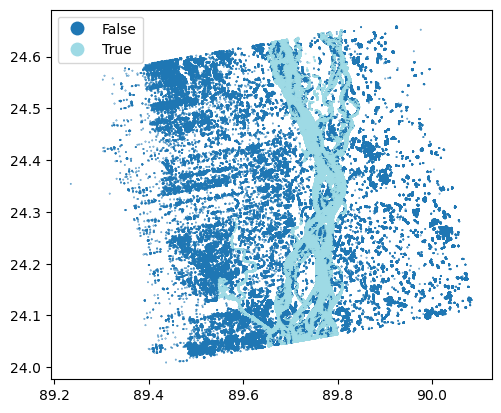

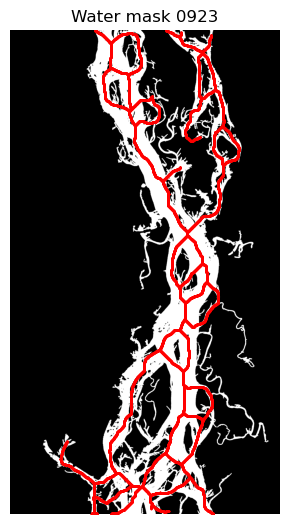

Reading in SWOT PIXC data...
No centerline buffer to trim to.
Trimming PIXC data to simplified water mask...
Running RiverSP processing for date... 20230910
Running channel... 1
No SWOT data around channel...skipping channel:  1
Running channel... 2
Buffer width not converged, max iteration reached.
Running channel... 3
No SWOT data around channel...skipping channel:  3
Running channel... 4
No SWOT data around channel...skipping channel:  4
Running channel... 5
Running channel... 6
Running channel... 7
Running channel... 8
Buffer width not converged, max iteration reached.
Running channel... 9
Running channel... 10
Running channel... 11
Running channel... 12
Running channel... 13
Buffer width not converged, max iteration reached.
Running channel... 14
Buffer width not converged, max iteration reached.
Running channel... 15
Running channel... 16
Running channel... 17
Running channel... 18
Running channel... 19
Buffer width not converged, max iteration reached.
Running channel... 20
Runn

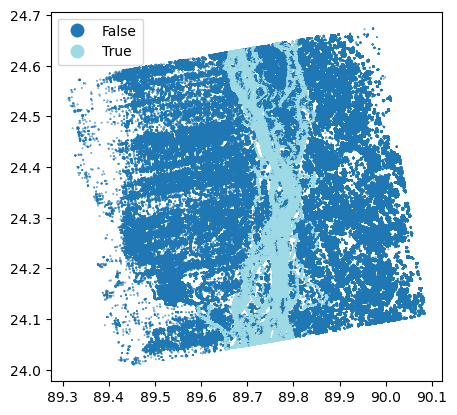

In [7]:
# ------------------------------ DYNAMICS ------------------------------
pixc_filenames = glob.glob("/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/*"+tileID+"*") 

pixc_filenames = [
  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_025_258_112L_20241212T041607_20241212T041618_PIC2_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_024_258_112L_20241121T073103_20241121T073114_PIC2_02.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_006_258_112L_20231111T175935_20231111T175946_PGC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_005_258_112L_20231021T211430_20231021T211441_PGC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_004_258_112L_20231001T002926_20231001T002937_PGC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_001_258_112L_20230730T101412_20230730T101423_PGC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_023_258_112L_20241031T104557_20241031T104608_PIC2_01.nc',
'/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_003_258_112L_20230910T034423_20230910T034434_PGC0_02.nc']

pixc_filenames = [
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_004_258_112L_20231001T002926_20231001T002937_PGC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_001_258_112L_20230730T101412_20230730T101423_PGC0_01.nc',
 '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_023_258_112L_20241031T104557_20241031T104608_PIC2_01.nc',
'/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_003_258_112L_20230910T034423_20230910T034434_PGC0_02.nc']


# pixc_filenames = ['/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_003_258_112L_20230910T034423_20230910T034434_PGC0_02.nc',
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_001_258_112L_20230730T101412_20230730T101423_PGC0_01.nc',
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_025_258_112L_20241212T041607_20241212T041618_PIC2_01.nc',
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_024_258_112L_20241121T073103_20241121T073114_PIC2_02.nc',
#  '/Volumes/OneTouch/work/SWOTC/brahmaputra/PIXC/SWOT_L2_HR_PIXC_023_258_112L_20241031T104557_20241031T104608_PIC2_01.nc']


for filename in pixc_filenames:

    pixcdate = os.path.basename(filename)[29:37]
    print('Runnning braided river analysis for:',str(pixcdate))

    maskdate, water_mask_tiff = pc.getNearestMaskDate(pixcdate, tileID, LFmonths, HFmonths)

    # Get season
    if int(maskdate[0:2]) in LFmonths:
        season='LF'
    else:
        season='HF'


    ### LOAD IN ONE GEN CL
    #cl_gen = gpd.read_file(odir+maskdate+'_generated_cl.geojson')
    cl_gen = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
    cl_gen = cl_gen.to_crs('EPSG:4326') 

    # LOAD IN MASK (dilate, take largest piece)
    water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/"+tileID+"/S2*"+str(maskdate)+".tif")[0]
    water_mask = skel.get_watermask(water_mask_tiff)
    dilated_mask = binary_dilation(water_mask, footprint=skel.createKernel(5)) # OG 10
    labeled_mask, num_features = label(dilated_mask, return_num=True)
    component_sizes = np.bincount(labeled_mask.ravel())
    component_sizes[0] = 0
    largest_component_mask = (labeled_mask == component_sizes.argmax())

    # PLOT mask and centerline
    fig, ax = plt.subplots(figsize=(3, 6))
    coords_df = cl_gen.get_coordinates()
    cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
    ax.imshow(largest_component_mask, cmap=plt.cm.gray)
    ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.2)
    ax.axis('off')
    ax.set_title('Water mask '+str(maskdate))

    plt.tight_layout()
    plt.show()

    # READ IN PIXC DATA and trim
    print('Reading in SWOT PIXC data...')
    pixc_gdf = pc.readPIXC(filename,gdf_buffered = []) # cl is a geodataframe

    # Trim data to mask
    print('Trimming PIXC data to simplified water mask...')
    trimmed_gdf, pixc_gdf = pc.trim2mask_general(pixc_gdf,largest_component_mask,water_mask_tiff) # Trimming to largest component mask

    ### Run RiverSP processing alg
    print('Running RiverSP processing for date...',pixcdate)
    riverSP_gdf = get_RiverSP(trimmed_gdf,cl_gen,hemi,season,pixcdate,tileID,figdir,odir,buffer_conv=50)

    print('SUCCESSFUL RiverSP extraction! Saving files...')
    isExist = os.path.exists(odir+'riverSP_out/'+tileID+'/')
    if not isExist:
        os.makedirs(odir+'riverSP_out/'+tileID+'/')
    riverSP_gdf = riverSP_gdf.dropna()
    riverSP_gdf.to_file(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
    print('SUCCESS!')



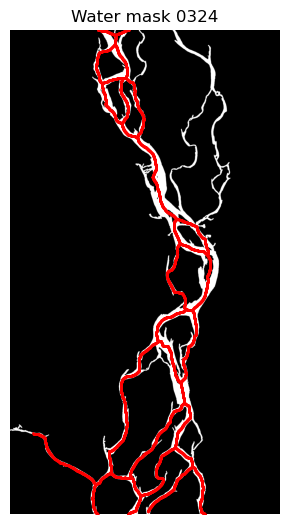

In [ ]:
# Running just one...

from skimage.morphology import binary_dilation

maskdate = '0324'
pixcdate = '20240315'
tileID = '258_112L'


### LOAD IN ONE GEN CL
#cl_gen = gpd.read_file(odir+maskdate+'_generated_cl.geojson')
cl_gen = gpd.read_file(odir+tileID+'/'+maskdate+'_generated_cl.geojson')
cl_gen = cl_gen.to_crs('EPSG:4326') 

# LOAD IN MASK (dilate, take largest piece)
water_mask_tiff = glob.glob("/Volumes/OneTouch/work/water_masks/brahmaputra/"+tileID+"/S2*"+str(maskdate)+".tif")[0]
water_mask = skel.get_watermask(water_mask_tiff)
dilated_mask = binary_dilation(water_mask, footprint=skel.createKernel(5)) # OG 10
labeled_mask, num_features = label(dilated_mask, return_num=True)
component_sizes = np.bincount(labeled_mask.ravel())
component_sizes[0] = 0
largest_component_mask = (labeled_mask == component_sizes.argmax())

# PLOT mask and centerline
fig, ax = plt.subplots(figsize=(3, 6))
coords_df = cl_gen.get_coordinates()
cl_pixel_coords = skel.latlon_to_pixel_coordinates(water_mask_tiff,coords_df.y,coords_df.x)
ax.imshow(largest_component_mask, cmap=plt.cm.gray)
ax.scatter(cl_pixel_coords.x,cl_pixel_coords.y,color='red',s=0.2)
ax.axis('off')
ax.set_title('Water mask '+str(maskdate))

plt.tight_layout()
plt.show()

# #### Read in SWOT data (and plot!)
# print('Reading in SWOT PIXC data....')
# swot_pixc = gpd.read_file(odir+pixcdate+'_pixc_gdf_wChannels.geojson')

# # READ IN PIXC DATA and trim
# print('Reading in SWOT PIXC data...')
# pixc_gdf = pc.readPIXC(filename,gdf_buffered = []) # cl is a geodataframe

# # Trim data to mask
# print('Trimming PIXC data to simplified water mask...')
# trimmed_gdf, pixc_gdf = pc.trim2mask_general(pixc_gdf,largest_component_mask,water_mask_tiff) # Trimming to largest component mask

# ### Run RiverSP processing alg
# print('Running RiverSP processing for date...',pixcdate)
# riverSP_gdf = get_RiverSP(trimmed_gdf,cl_gen,hemi,season,pixcdate,tileID,figdir,odir,buffer_conv=50)

# print('SUCCESSFUL RiverSP extraction! Saving files...')
# isExist = os.path.exists(odir+'riverSP_out/'+tileID+'/')
# if not isExist:
#     os.makedirs(odir+'riverSP_out/'+tileID+'/')
# riverSP_gdf = riverSP_gdf.dropna()
# riverSP_gdf.to_file(odir+'riverSP_out/'+tileID+'/'+pixcdate+'_riverSP.geojson')
# print('SUCCESS!')
# print(riverSP_gdf.head(10))





.......running width extraction for ch.  18
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


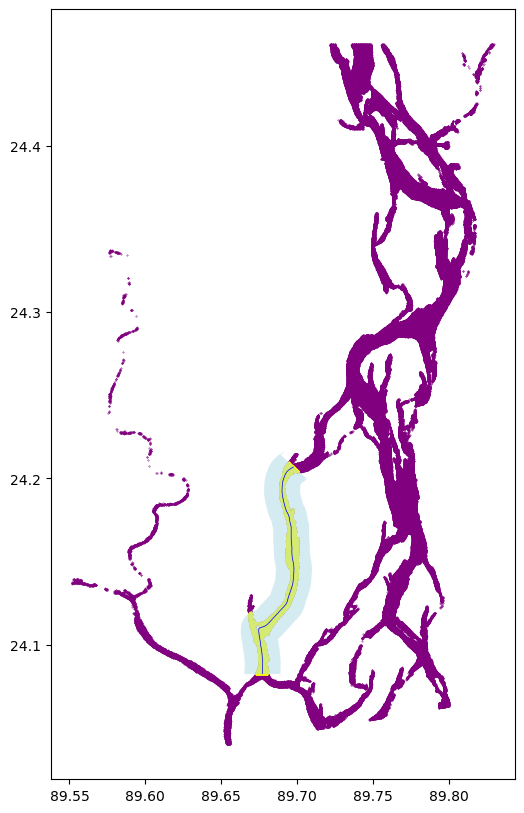

Extracting transects, widths and heights...
Median width of channel: 505.5292376774155
Updating buffer width: 556.0
Extracting SWOT data within channel buffer...


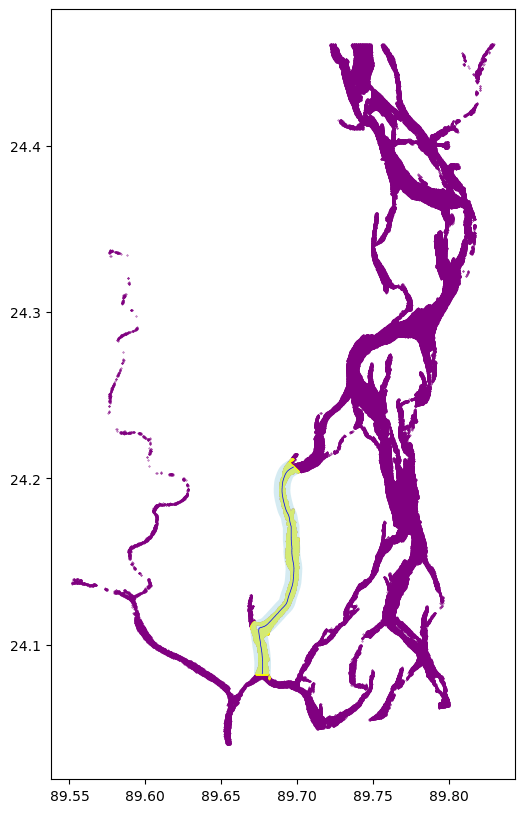

Extracting transects, widths and heights...
Median width of channel: 510.63236309417806
Final channel width: 510.63236309417806
Final buffer width: 556.0
.......running width extraction for ch.  19
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


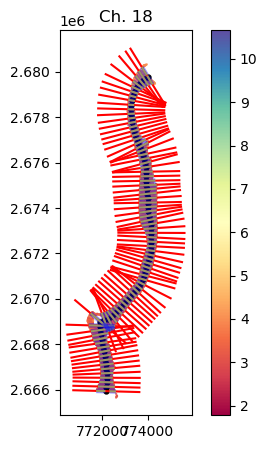

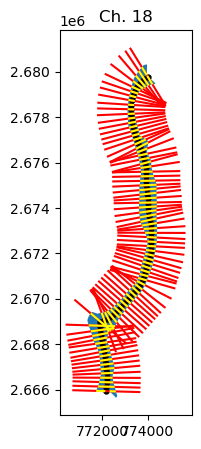

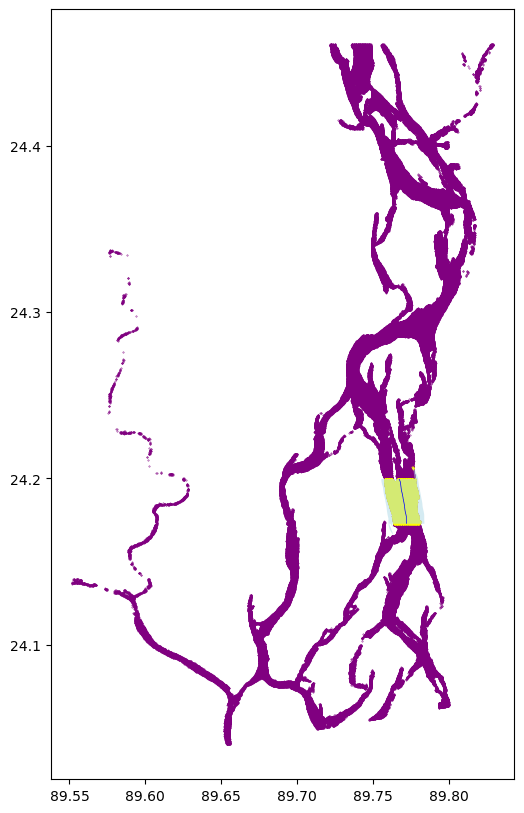

Extracting transects, widths and heights...
Median width of channel: 1759.5472270115533
Updating buffer width: 1936.0
Extracting SWOT data within channel buffer...


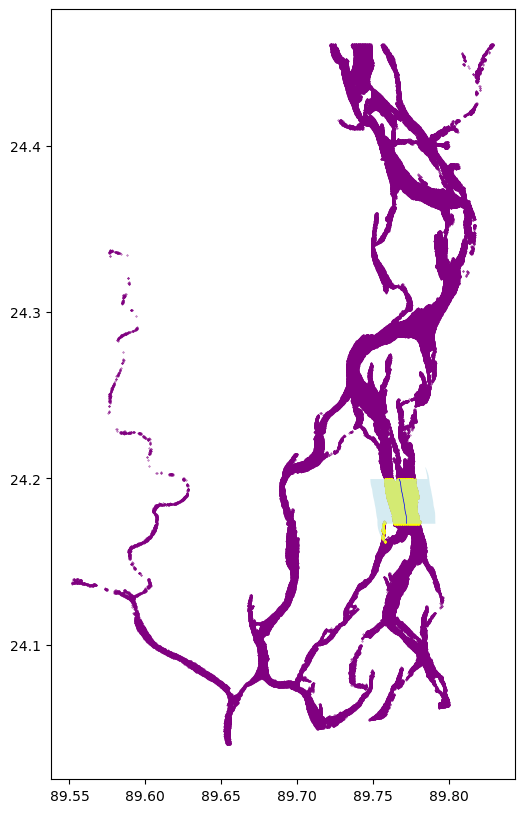

Extracting transects, widths and heights...
Median width of channel: 1780.652836551369
Final channel width: 1780.652836551369
Final buffer width: 1936.0
.......running width extraction for ch.  20
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


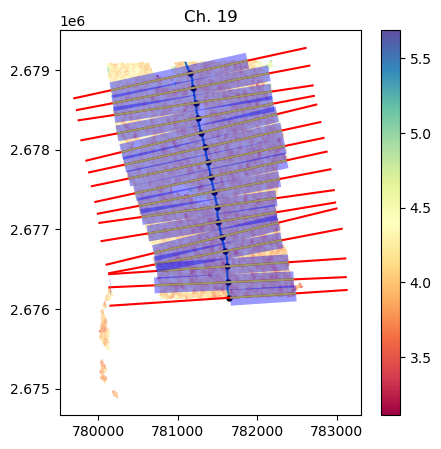

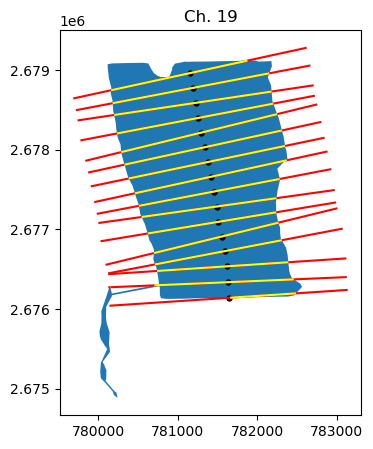

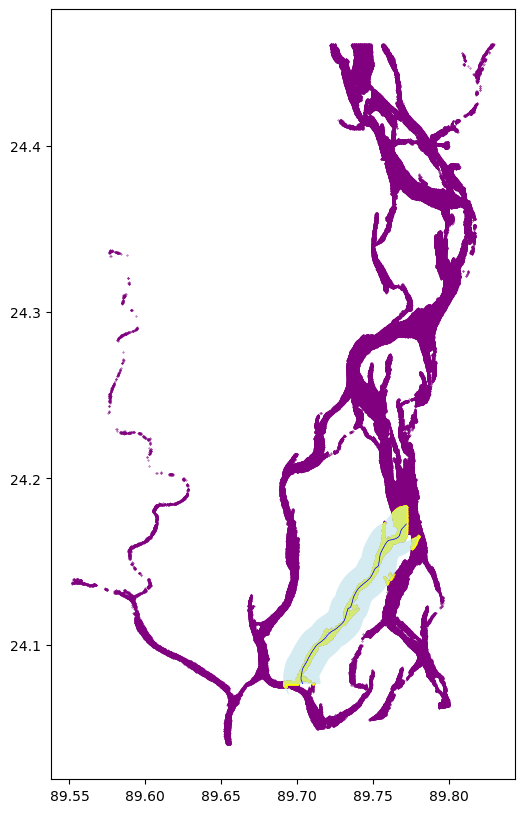

Extracting transects, widths and heights...
Median width of channel: 383.52260950649287
Updating buffer width: 422.0
Extracting SWOT data within channel buffer...


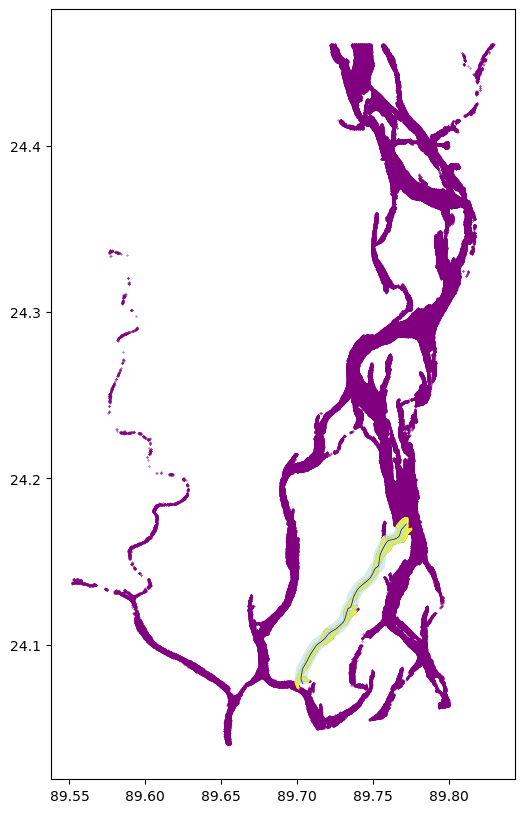

Extracting transects, widths and heights...
Median width of channel: 346.8974114985026
Final channel width: 346.8974114985026
Final buffer width: 422.0
.......running width extraction for ch.  21
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


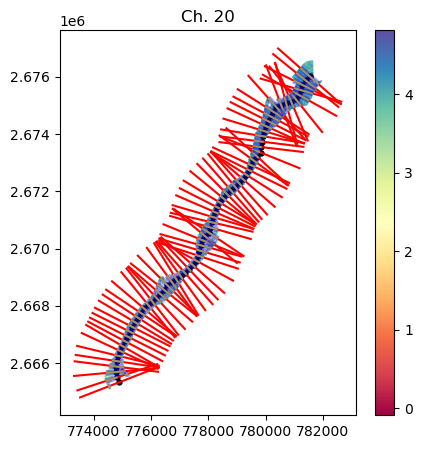

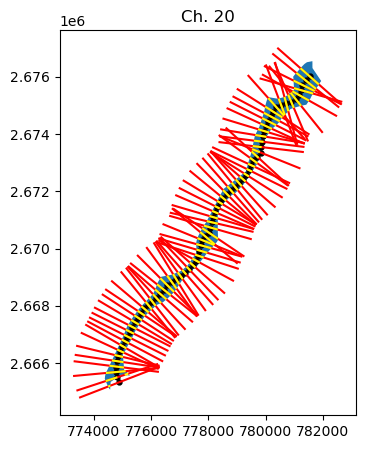

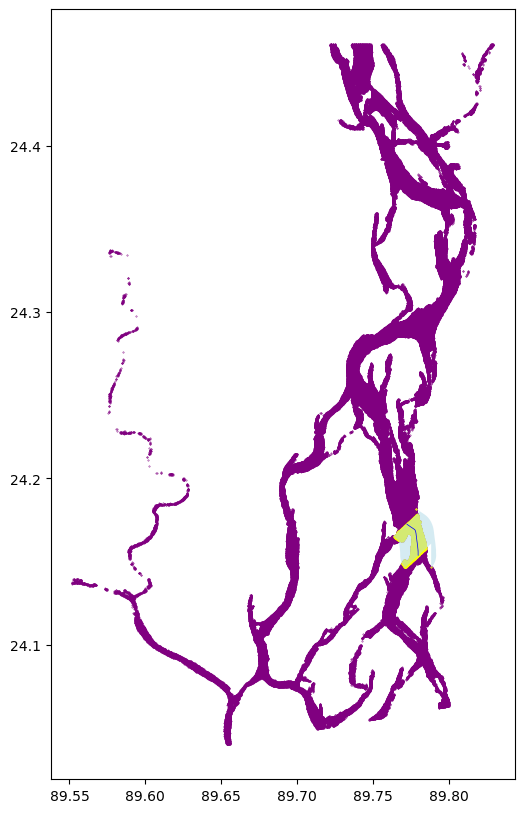

Extracting transects, widths and heights...
Median width of channel: 946.8916288928017
Updating buffer width: 1042.0
Extracting SWOT data within channel buffer...


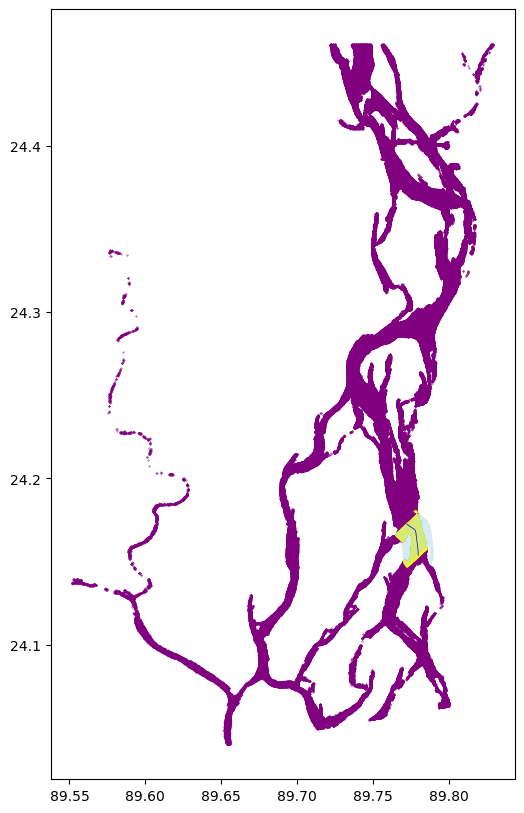

Extracting transects, widths and heights...
Median width of channel: 522.326810800074
Updating buffer width: 575.0
Extracting SWOT data within channel buffer...


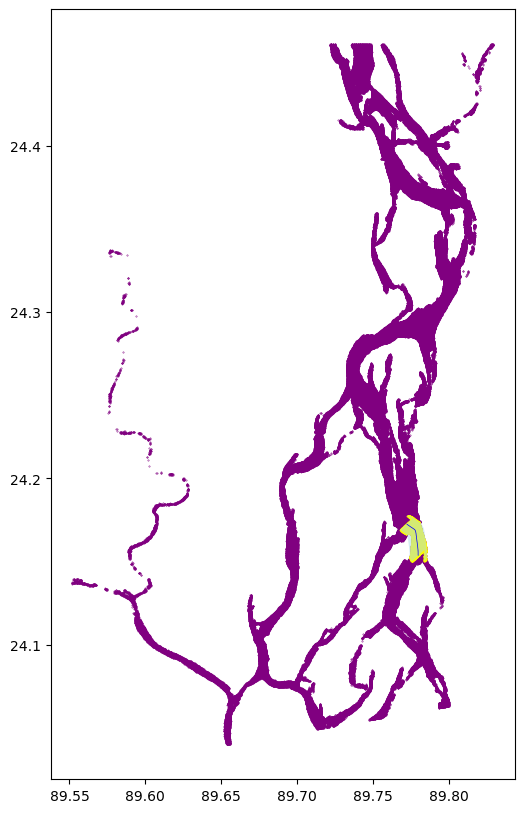

Extracting transects, widths and heights...
Median width of channel: 640.532584301937
Updating buffer width: 705.0
Extracting SWOT data within channel buffer...


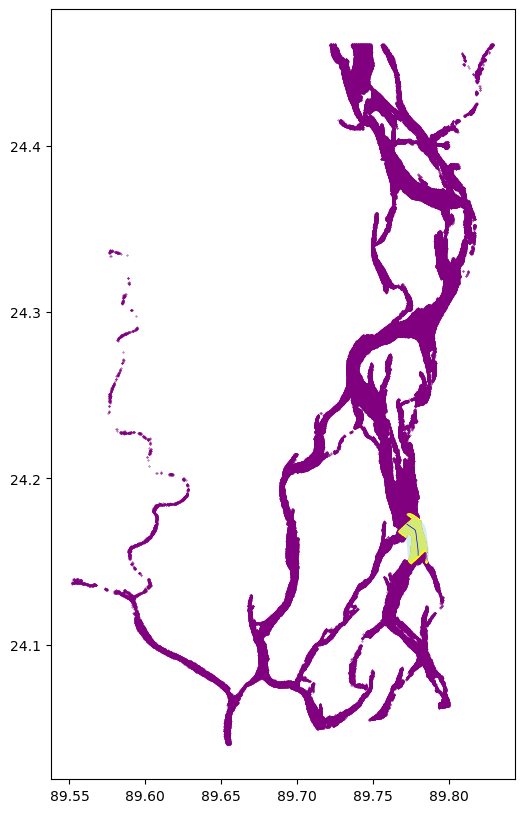

Extracting transects, widths and heights...
Median width of channel: 648.5248501310898
Final channel width: 648.5248501310898
Final buffer width: 705.0
.......running width extraction for ch.  22
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


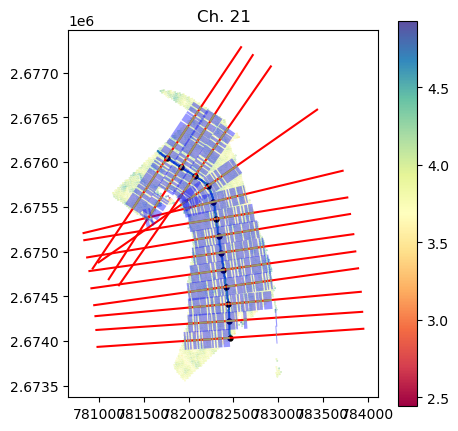

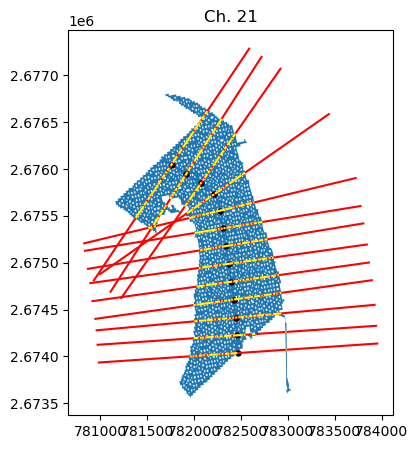

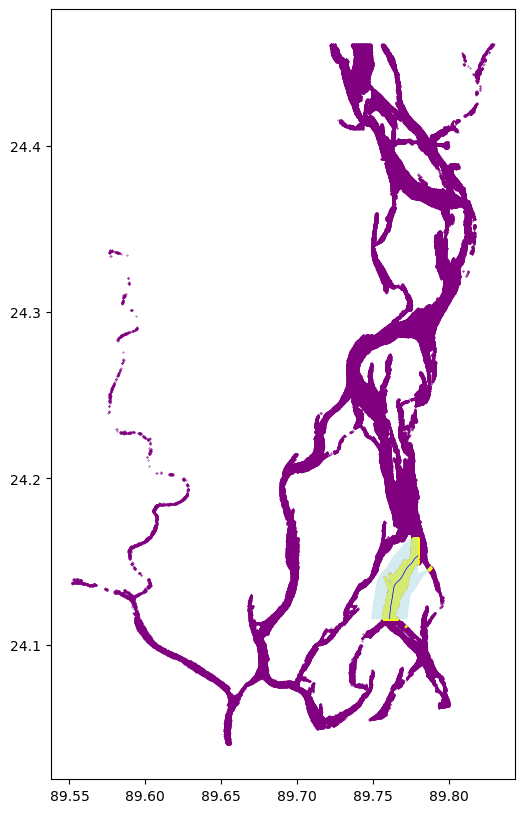

Extracting transects, widths and heights...
Median width of channel: 831.1555057402935
Updating buffer width: 914.0
Extracting SWOT data within channel buffer...


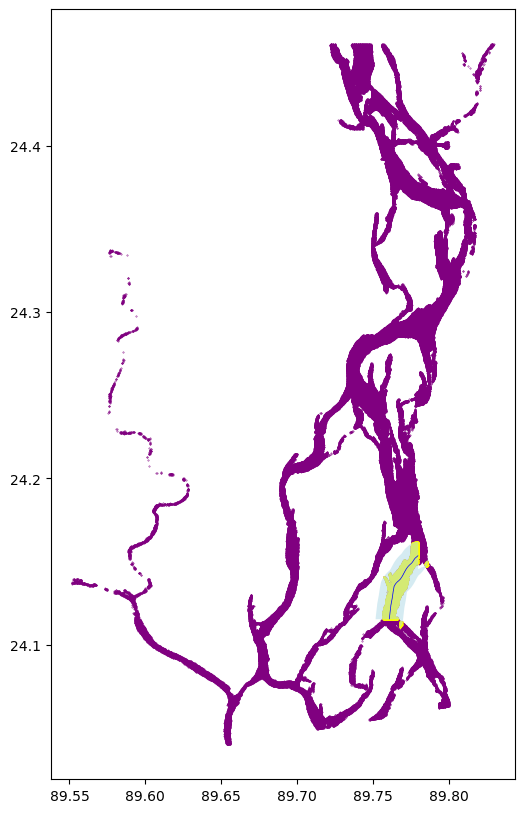

Extracting transects, widths and heights...
Median width of channel: 815.5251310782454
Final channel width: 815.5251310782454
Final buffer width: 914.0
.......running width extraction for ch.  23
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


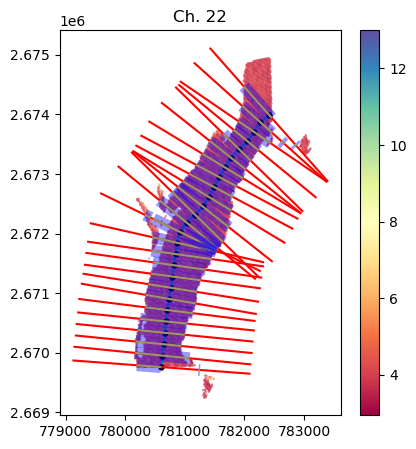

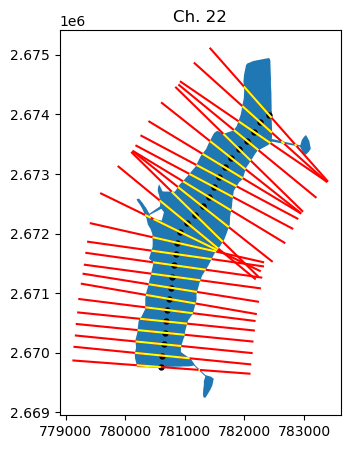

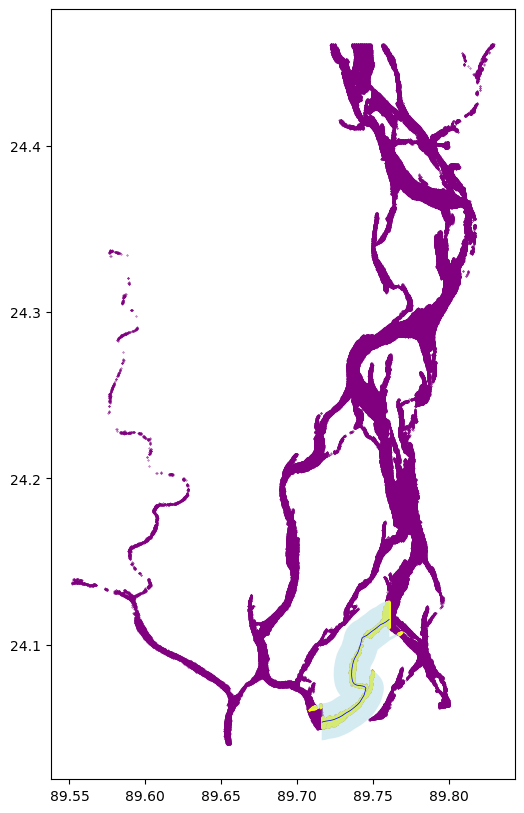

Extracting transects, widths and heights...


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Median width of channel: 339.35730317697187
Updating buffer width: 373.0
Extracting SWOT data within channel buffer...


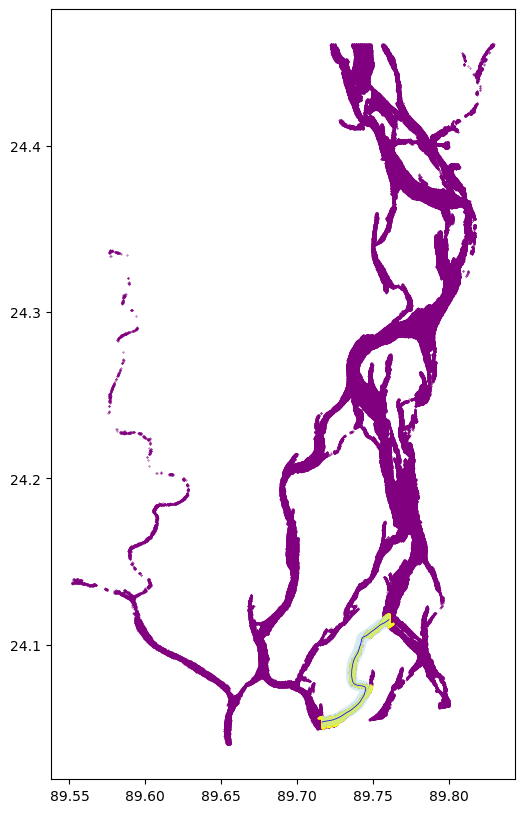

Extracting transects, widths and heights...


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Median width of channel: 292.73856823791203
Updating buffer width: 322.0
Extracting SWOT data within channel buffer...


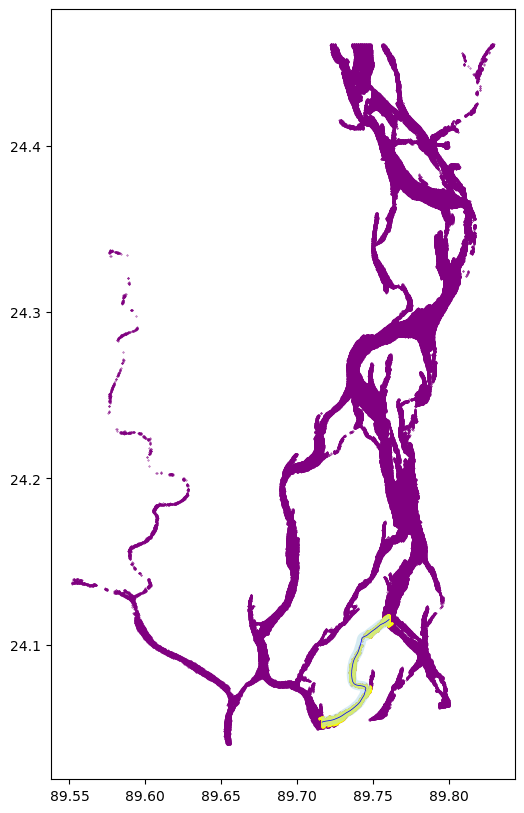

Extracting transects, widths and heights...


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Median width of channel: 292.73856823791203
Final channel width: 292.73856823791203
Final buffer width: 322.0
.......running width extraction for ch.  24
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


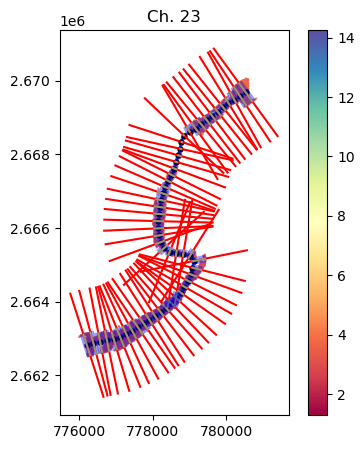

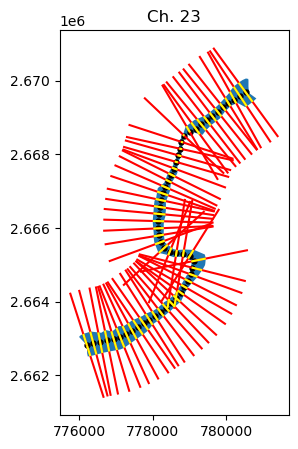

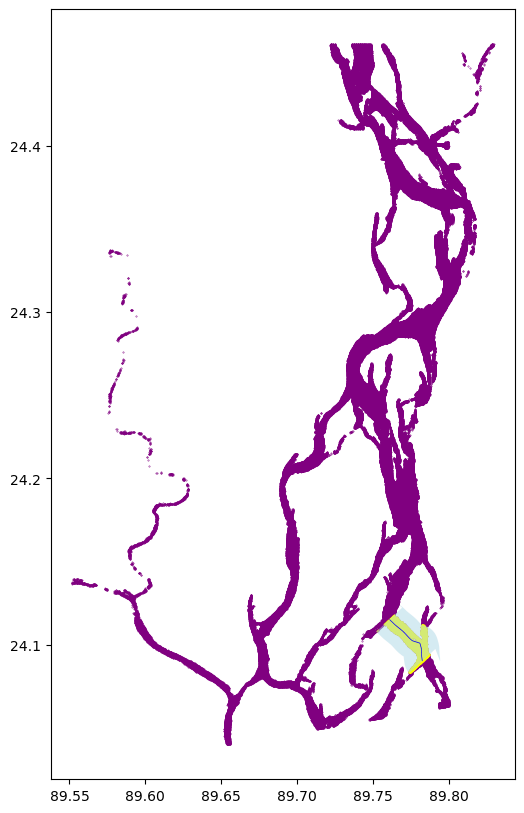

Extracting transects, widths and heights...
Median width of channel: 734.5781190042273
Updating buffer width: 808.0
Extracting SWOT data within channel buffer...


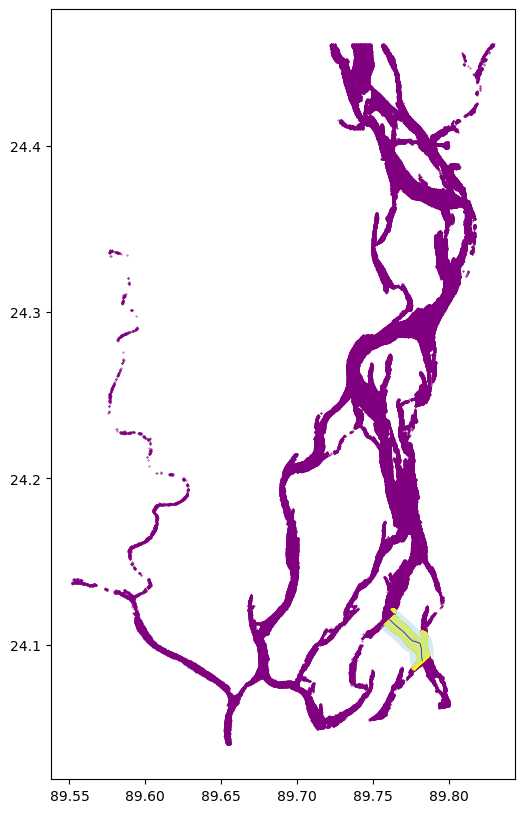

Extracting transects, widths and heights...
Median width of channel: 734.5781190042273
Final channel width: 734.5781190042273
Final buffer width: 808.0
.......running width extraction for ch.  25
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


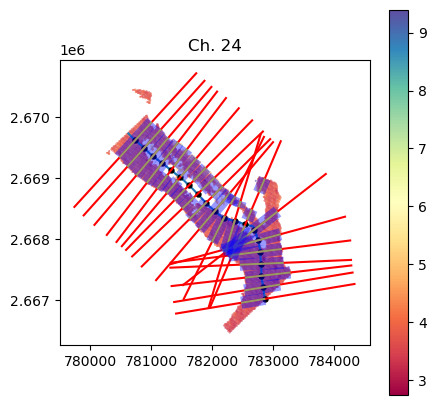

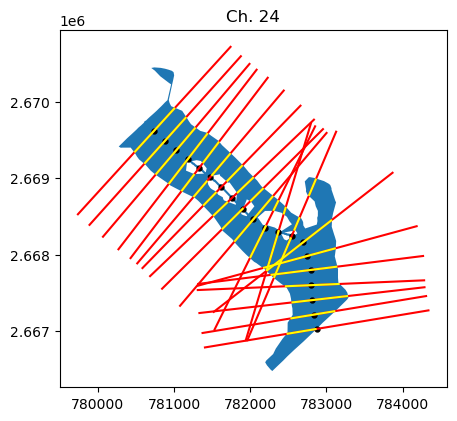

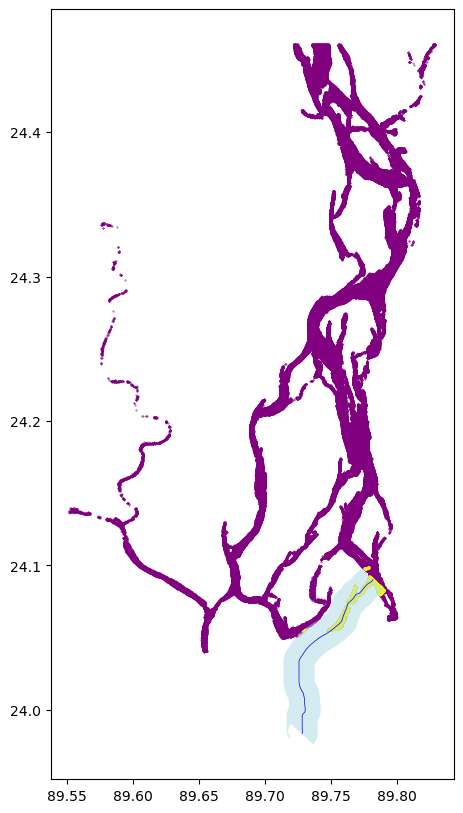

Extracting transects, widths and heights...


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/li

Median width of channel: 2.7481402412833633
Updating buffer width: 3.0
Extracting SWOT data within channel buffer...


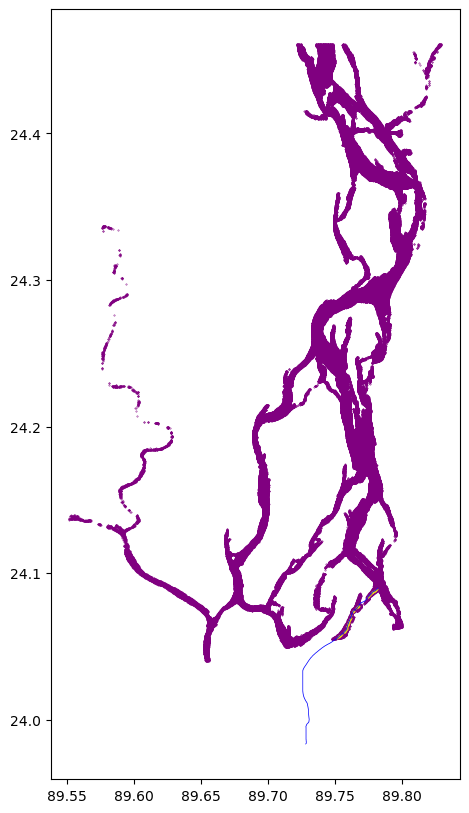

Extracting transects, widths and heights...


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/li

Median width of channel: 0.0
Final channel width: 0.0
Final buffer width: 3.0
.......running width extraction for ch.  26
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


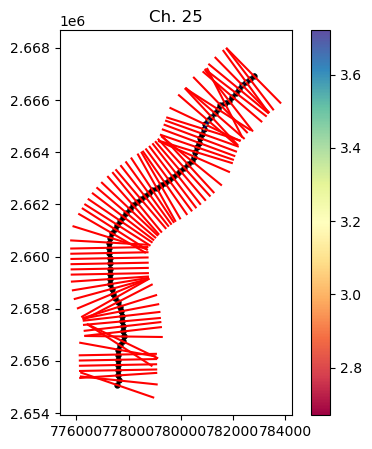

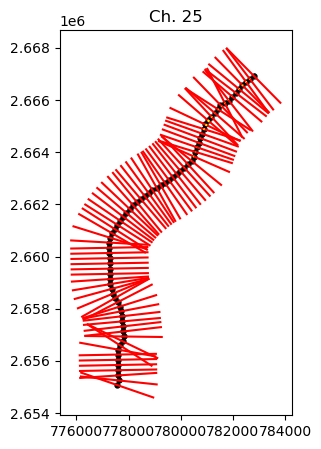

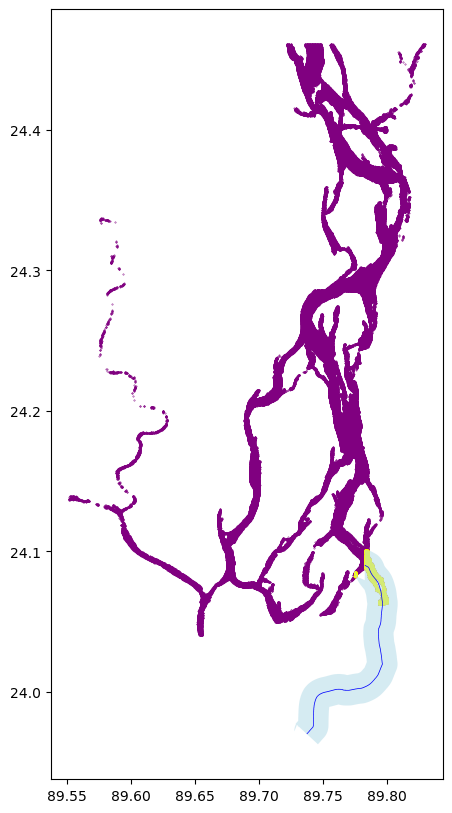

Extracting transects, widths and heights...


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/li

Median width of channel: 0.0
Updating buffer width: 0.0
Extracting SWOT data within channel buffer...


/var/folders/z8/rwrj_7dn6nv6_d2803hqbzc00000gn/T/ipykernel_94568/4006241238.py:87: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  dissolved_geometry = gdf.buffered_geometry.unary_union
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/array.py:1019: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/array.py:1020: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/array.py:1021: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/array.py:1022: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy
/Users/sarahfranze/miniforge3/envs/swotPu

Extracting transects, widths and heights...


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/li

Median width of channel: 0.0
Final channel width: 0.0
Final buffer width: 0.0


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


.......running width extraction for ch.  27
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


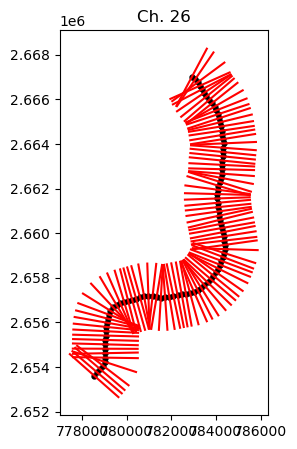

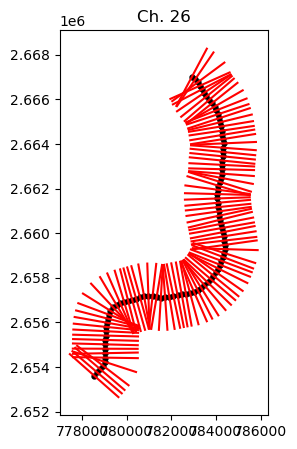

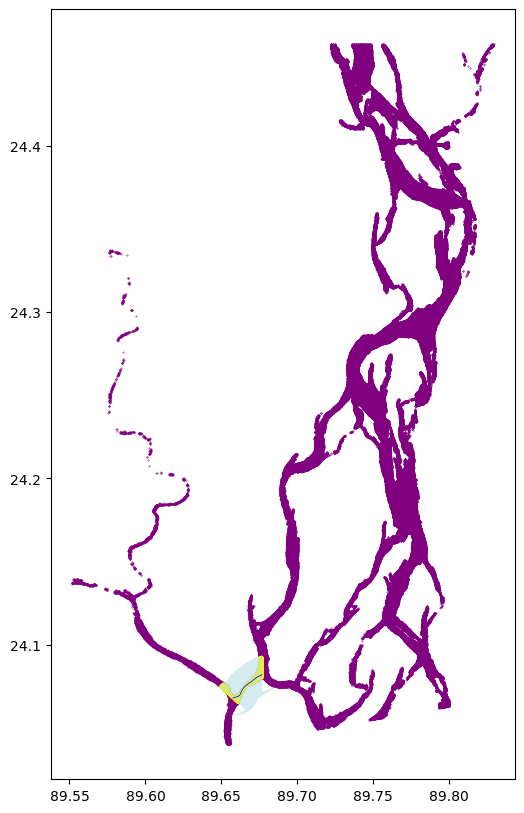

Extracting transects, widths and heights...
Median width of channel: 140.34261725570207
Updating buffer width: 154.0
Extracting SWOT data within channel buffer...


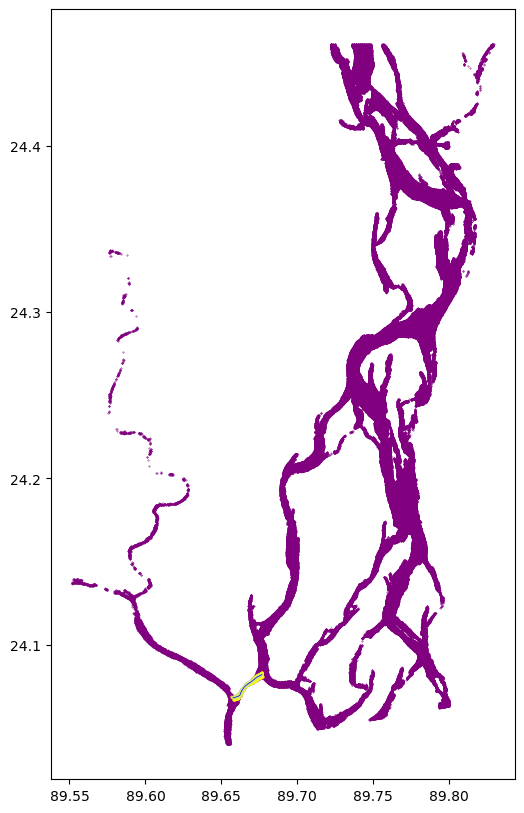

Extracting transects, widths and heights...
Median width of channel: 162.44383333131822
Final channel width: 162.44383333131822
Final buffer width: 154.0
.......running width extraction for ch.  28
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


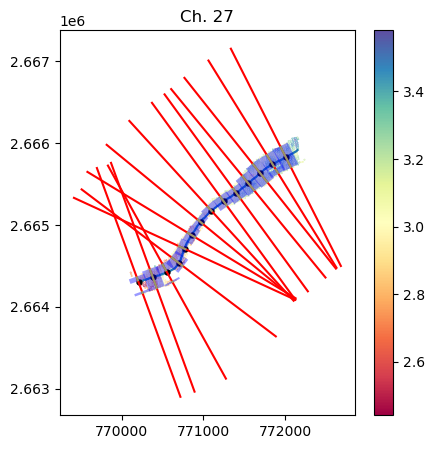

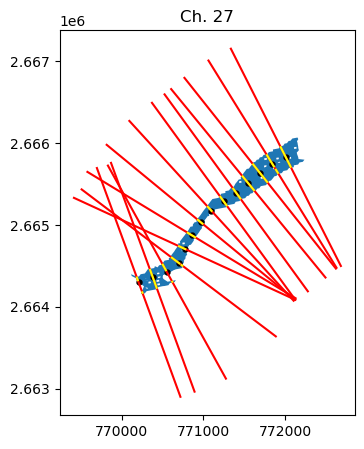

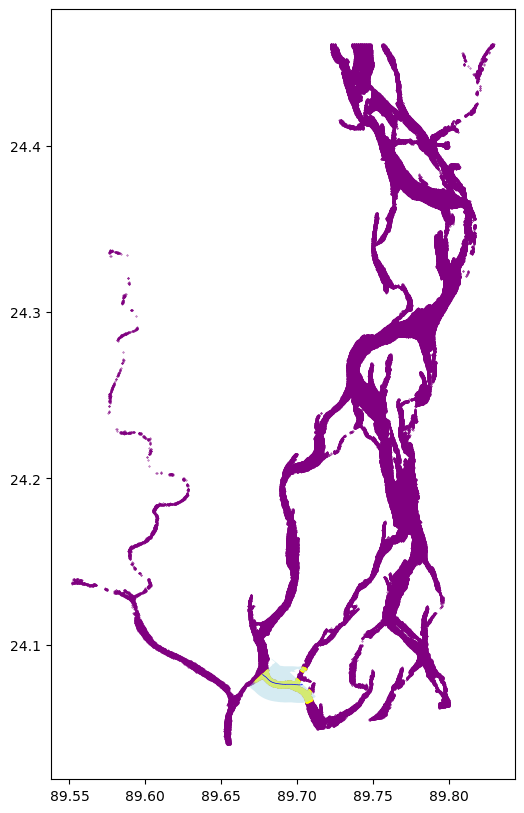

Extracting transects, widths and heights...
Median width of channel: 367.6453879032282
Updating buffer width: 404.0
Extracting SWOT data within channel buffer...


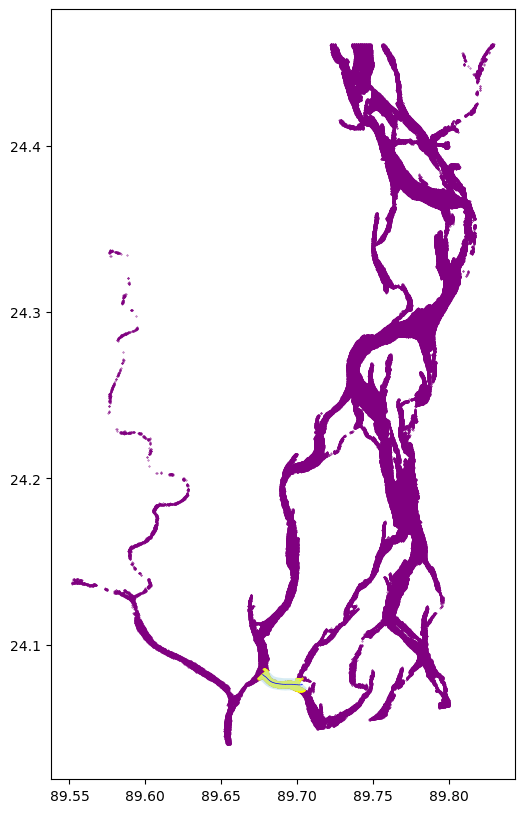

Extracting transects, widths and heights...
Median width of channel: 357.4441296581071
Final channel width: 357.4441296581071
Final buffer width: 404.0
.......running width extraction for ch.  29
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


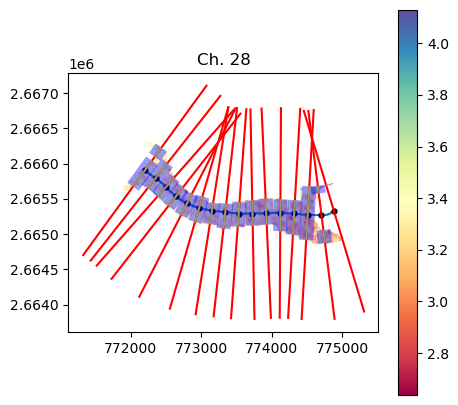

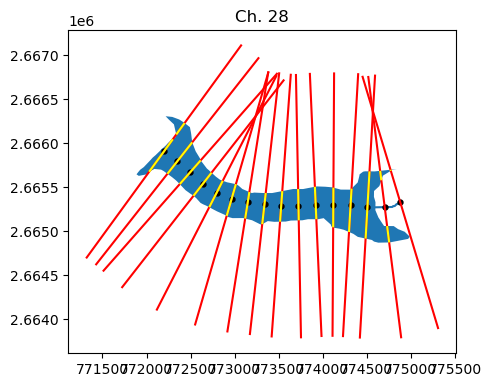

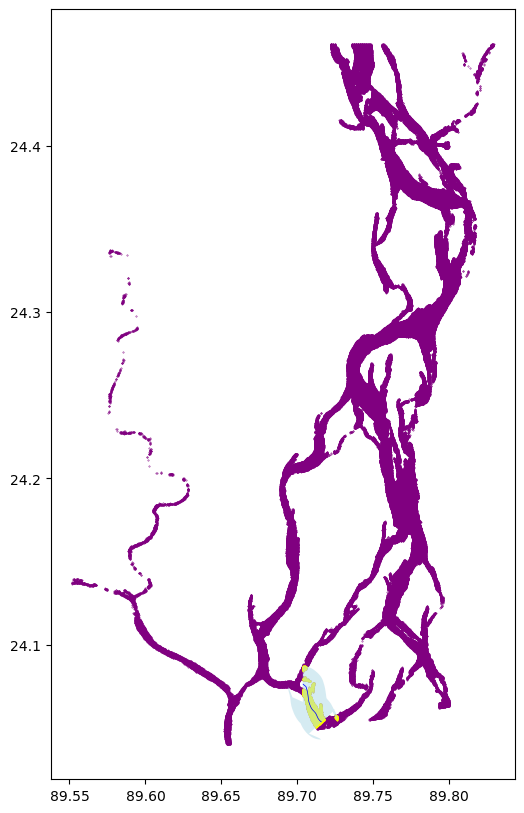

Extracting transects, widths and heights...


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Median width of channel: 500.74916826427295
Updating buffer width: 551.0
Extracting SWOT data within channel buffer...


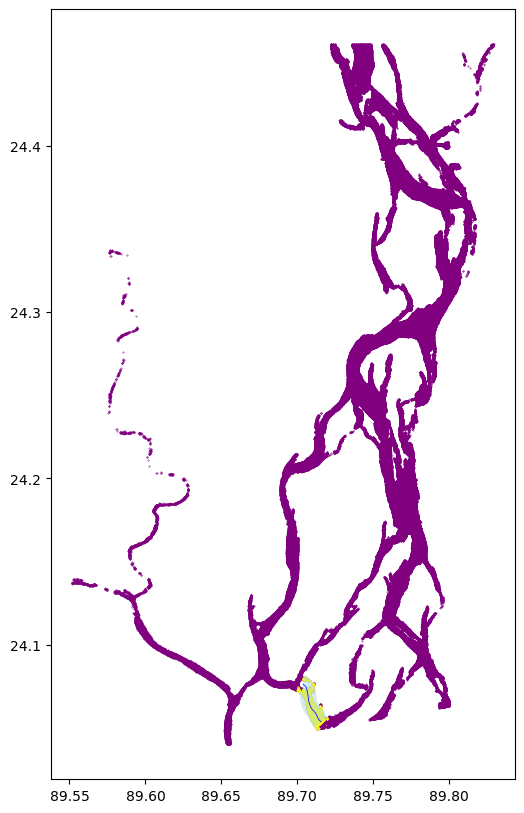

Extracting transects, widths and heights...
Median width of channel: 474.7679419732947
Final channel width: 474.7679419732947
Final buffer width: 551.0
.......running width extraction for ch.  30
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


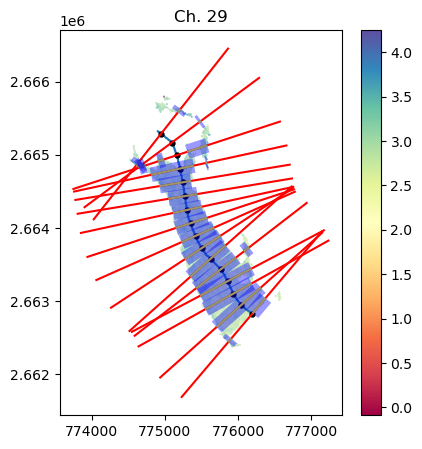

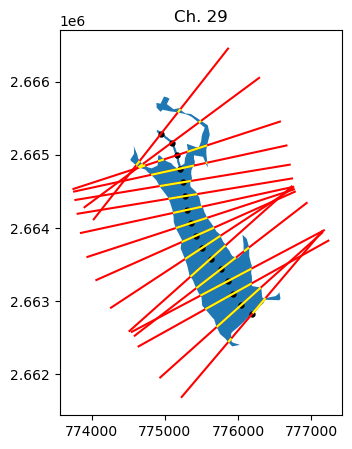

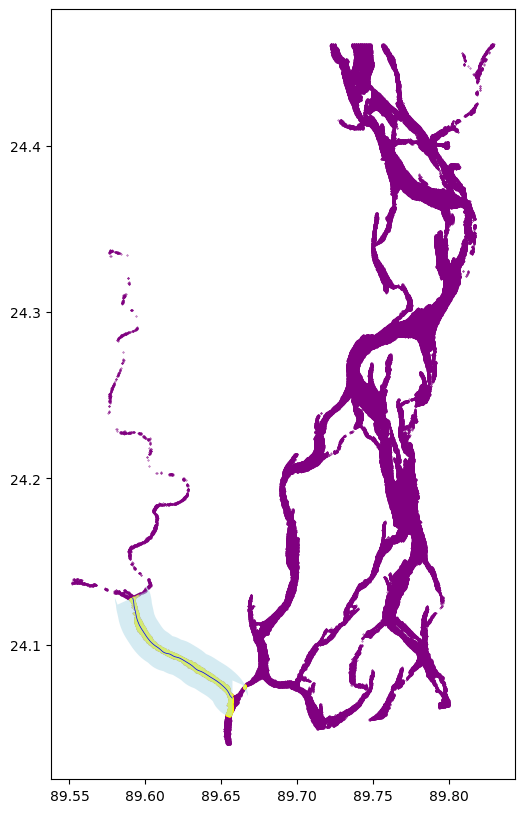

Extracting transects, widths and heights...
Median width of channel: 325.476667561509
Updating buffer width: 358.0
Extracting SWOT data within channel buffer...


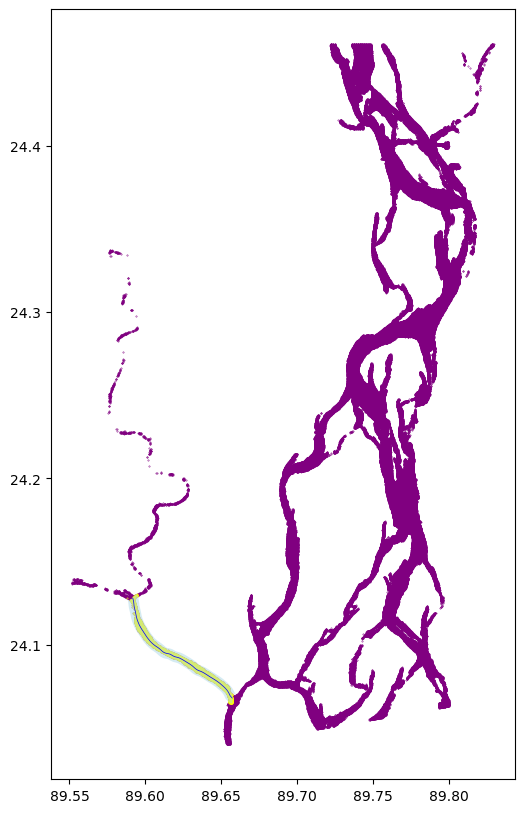

Extracting transects, widths and heights...
Median width of channel: 323.107086949524
Final channel width: 323.107086949524
Final buffer width: 358.0
.......running width extraction for ch.  31
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


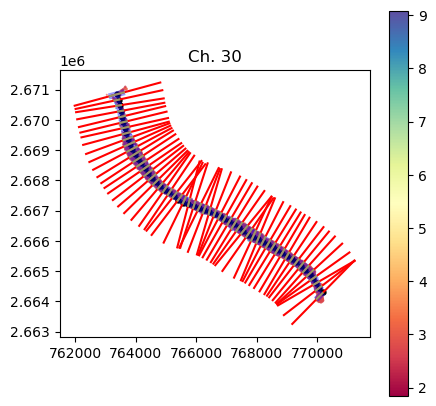

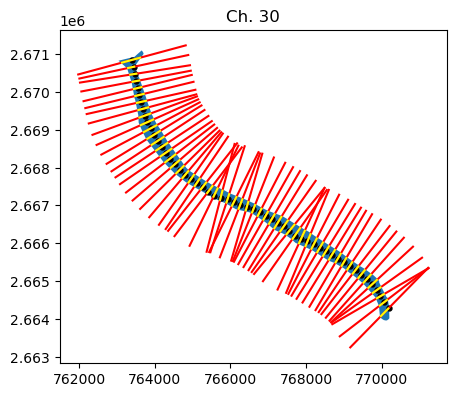

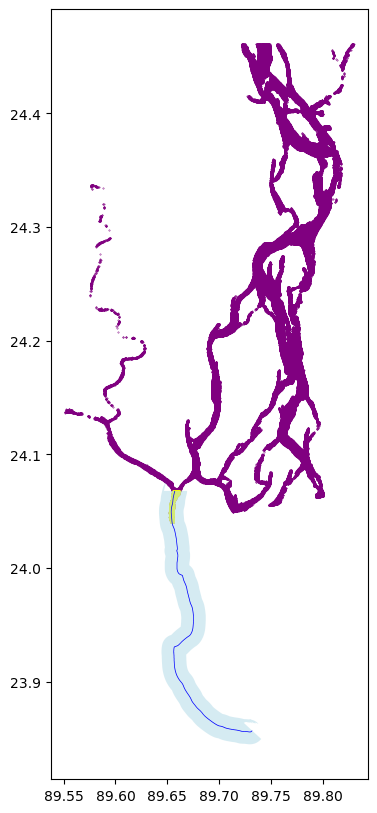

Extracting transects, widths and heights...


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sarahfranze/miniforge3/envs/swotPull/li

Median width of channel: 0.0
Updating buffer width: 0.0
Extracting SWOT data within channel buffer...
Extracting transects, widths and heights...


/var/folders/z8/rwrj_7dn6nv6_d2803hqbzc00000gn/T/ipykernel_94568/4006241238.py:87: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  dissolved_geometry = gdf.buffered_geometry.unary_union
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/array.py:1019: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/array.py:1020: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/array.py:1021: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/array.py:1022: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy
/Users/sarahfranze/miniforge3/envs/swotPu

Median width of channel: 0.0
Final channel width: 0.0
Final buffer width: 0.0


/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
/var/folders/z8/rwrj_7dn6nv6_d2803hqbzc00000gn/T/ipykernel_94568/3336972252.py:185: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sub_swot_utm.plot(ax=ax, column='heightEGM', markersize=0.1, legend=True,cmap='Spectral')
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been disp

.......running width extraction for ch.  32
Updating buffer width: 1200
Extracting SWOT data within channel buffer...


KeyboardInterrupt: 

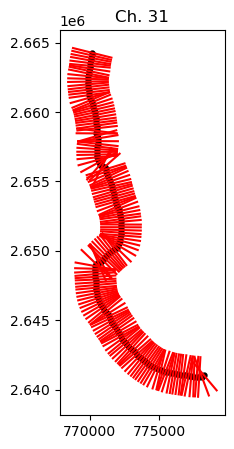

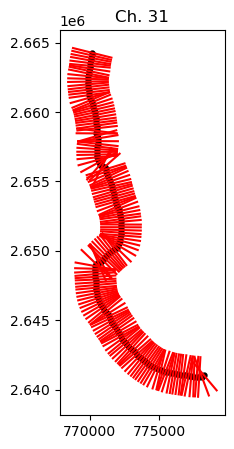

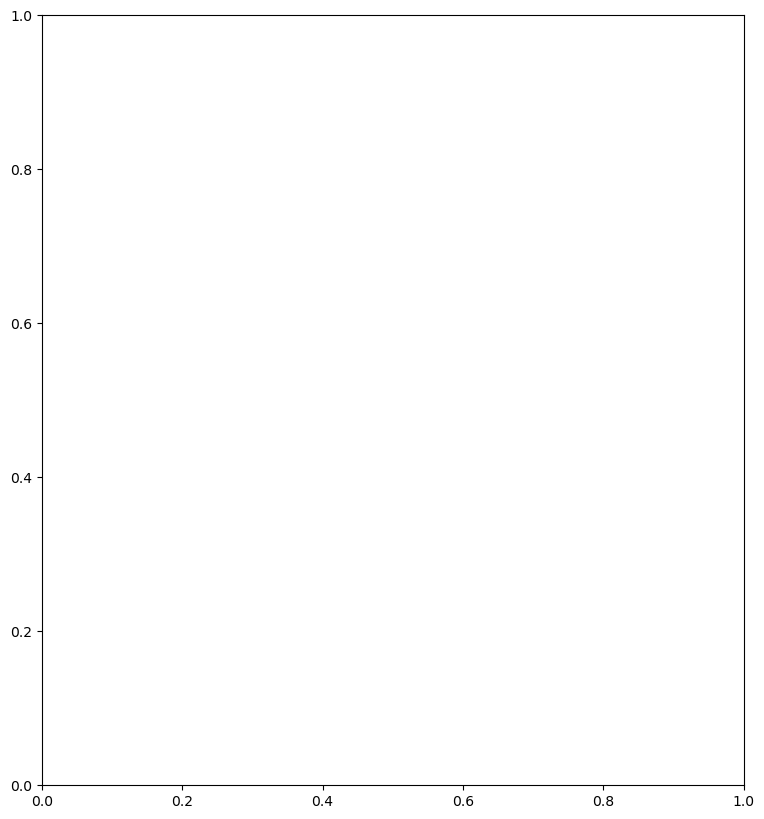

In [24]:
##################### (development code) GENERATING RIVERSP PRODUCT FOR BRAIDED CHANNELS #####################

# 1. Loop through each branch
#       - Calculate 200 m spaced out points on centerline
#       - Determine vector perpendicular to the centerline at these points
#       - Create polygon based on SWOT point locations
#       - Find intersection line of perpendicular vector and SWOT polygon
#       - Summed length of all components of intersecting line: pixel width
#       - Buffer flat-end rectangle around intersecting line (100 m radius)
#       - Take median height value of points within this polygon
#       - If channel contains only one point (ie it is less than 200 m in length): skip channel (no representative points in RiverSP product)


# Potential flow:
# - Load in mask trimmed pixc data
# - use this method to determine widths at transects
# - buffer channel by median width value
# - re-determine node width values
# iterate until buffer width is unchanging (dw < 50 m)
# - save RiverSP product with channel ID ( can then project onto selected centerline and plot slope )
# - option here to apply path finding algorithm dependant on width cost function (find two best routes dependant on width value from a startin coordinate)
# - option also to filter channels by median width (keep channels larger than ex 200 m wide)

# For rotating the buffer
from shapely.geometry import MultiPoint, shape
import shapely

theta = np.radians(90)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c))) #2D rotation matrix

riverSP_gdf = gpd.GeoDataFrame() # initialize dataframe

for channelID in cl_gen.branch_id[17:-1]:

    print('.......running width extraction for ch. ',channelID)
    
    # Select channel
    sel_channel = cl_gen.loc[cl_gen.branch_id == channelID]

    # convert to UTM
    centroid = sel_channel.geometry.unary_union.centroid
    utm_zone = int((centroid.x + 180) // 6) + 1
    if hemi == 'north':
        utm_crs = f'EPSG:{32600 + utm_zone}'
    elif hemi == 'south':
        utm_crs = f'EPSG:{32700 + utm_zone}'
    else:
        raise ValueError("Invalid hemisphere. Use 'north' or 'south'.")

    sel_channel_utm = sel_channel.to_crs(utm_crs)
    coords_list = list(sel_channel_utm.geometry.iloc[0].coords)
    x_coords = [x for x,y in coords_list]
    y_coords = [y for x,y in coords_list]

    # extract point locations every 100 m along the line
    sel_channel_utm["point_list"] = sel_channel_utm.apply(lambda x: create_points(row=x, point_separation=200), axis=1)

    #Create a point dataframe by exploding the point list into individual points/rows
    points_df = sel_channel_utm.explode(column="point_list")
    points_df = points_df.set_geometry("point_list").drop(columns="geometry").rename_geometry("geometry").set_crs(sel_channel_utm.crs)
    points_df = points_df.reset_index(drop=True)

    ## !!!!!!! edit here later..
    # Select SWOT data in this channel and transform to UTM (LATER - here is where you would select data based on an overestimation of the buffer)
    # sub_swot = trimmed_gdf.loc[trimmed_gdf.channelID == channelID] #OLD
    # sub_swot_utm = sub_swot.to_crs(utm_crs)

    # Extract data from SWOT PIXC based on large manual buffer (larger than any expected channel width)
    # Get season
    if int(maskdate[0:2]) in LFmonths:
        init_buffer_width = 1200
    else:
        init_buffer_width = 2000

    buffer_width_prev = init_buffer_width*100 # set large previous buffer width to begin with
    buffer_width = init_buffer_width

    while abs(buffer_width - buffer_width_prev) > 50:

        print('Updating buffer width:',buffer_width)

        print('Extracting SWOT data within channel buffer...')
        sub_swot = trim_to_one_channel(sel_channel, trimmed_gdf,hemi,buffer_width=buffer_width,savePlot=True) # Extracts SWOT data for one channel
        sub_swot_utm = sub_swot.to_crs(utm_crs)

        # Give each PIXC cloud point a point geometry
        mpt = MultiPoint([shape(row['geometry']) for _, row in sub_swot_utm.iterrows()])

        ratioval = 0.01
        if float(sel_channel_utm.geometry.length) > 3000: # change ratio value for SWOT extent polygon determination based on selected channel reach length
            ratioval = 0.05

        shapeout = shapely.concave_hull(mpt, ratio=ratioval,allow_holes=True)
        swot_boundary = gpd.GeoDataFrame(geometry=[shapeout],crs=utm_crs)

        # save transects to a gdf for plotting
        transects_gdf = gpd.GeoDataFrame() # initialize dataframe
        intersects_gdf = gpd.GeoDataFrame() # initialize dataframe
        extract_polys = gpd.GeoDataFrame() # initialize dataframe
        riverSP_gdf_oneChannel = gpd.GeoDataFrame() # initialize dataframe for saving single channels


        if len(points_df) <= 1:
            print('Channel contains only one point....skipping channel No. ',channelID)
            continue

        print('Extracting transects, widths and heights...')
        for idx in points_df.index:
            coord = list(points_df.geometry.iloc[idx].coords)
            if idx == 0:
                coord_b4 = coord
                coord_af = list(points_df.geometry.iloc[idx+1].coords)

            if idx == len(points_df.index) - 1:
                coord_b4 = list(points_df.geometry.iloc[idx-1].coords)
                coord_af = coord


            if idx != len(points_df.index) - 1 and idx != 0:
                coord_b4 = list(points_df.geometry.iloc[idx-1].coords)
                coord_af = list(points_df.geometry.iloc[idx+1].coords)

            coord_b4 = [coord_b4[0][0],coord_b4[0][1]]
            coord_af = [coord_af[0][0],coord_af[0][1]]

            # Compute vector and rotated vector
            vec = calculate_vector_general(coord_b4,coord_af)
            rot_vec = np.dot(vec, R)

            pt1 = np.array(coord) - 1500*rot_vec
            pt2 = np.array(coord) + 1500*rot_vec
            line = LineString([Point(pt1),Point(pt2)])
            # plot transect

            transect_temp = gpd.GeoDataFrame(geometry=[line],crs=points_df.crs)
            transects_gdf = pd.concat([transects_gdf,transect_temp])

            # Find intersection line with swot polygon
            inter_geom = shapely.intersection(swot_boundary,transect_temp)
            intersects_gdf = pd.concat([intersects_gdf,inter_geom])
            
            # Extract 100 m buffer poly around line (for med H estimation)
            extract_poly = inter_geom.geometry.iloc[0].buffer(100,cap_style="flat")
            extract_poly_gdf = gpd.GeoDataFrame(geometry=[extract_poly],crs=utm_crs)
            extract_polys = pd.concat([extract_polys,extract_poly_gdf])

            sub_swot_utm['inPoly']=extract_poly_gdf.geometry.iloc[0].contains(sub_swot_utm.geometry)
            subset = sub_swot_utm[sub_swot_utm['inPoly']==True]
            #subset.plot(ax=ax,column='heightEGM',cmap='Spectral',markersize=0.1, legend=True)

            lineW =inter_geom.geometry.length
            medH = np.median(subset.heightEGM)
            # print('median H:',medH)
            # print('width:',lineW)

            # Save to RiverSP GDF with point geometry
            riverSP_temp = gpd.GeoDataFrame(geometry=[Point(coord)],crs=utm_crs)
            riverSP_temp['heightEGM_med'] = medH
            riverSP_temp['width'] = lineW
            riverSP_temp['channelID'] = channelID
            nodeID = str(channelID) + str(idx)
            riverSP_temp['nodeID'] = nodeID

            riverSP_gdf_oneChannel = pd.concat([riverSP_gdf_oneChannel,riverSP_temp])
        
        # Update buffer width condition
        medW = np.median(riverSP_gdf_oneChannel.width)
        buffer_width_prev = buffer_width
        buffer_width = np.round(medW*1.1) # buffer with 10% extra of the median width

        print('Median width of channel:',medW)
        
    
    print('Final channel width:',medW)
    print('Final buffer width:',buffer_width_prev)
    riverSP_gdf = pd.concat([riverSP_gdf,riverSP_gdf_oneChannel])


    # Plot selected channel centerline, extracted points, and transects for each channel
    ax = sel_channel_utm.plot(figsize=(5,5))
    points_df.plot(ax=ax, zorder=2, color="black", markersize=50, marker=".")
    transects_gdf.plot(ax=ax, zorder=2, color="red")
    intersects_gdf.plot(ax=ax, zorder=2, color="yellow")
    sub_swot_utm.plot(ax=ax, column='heightEGM', markersize=0.1, legend=True,cmap='Spectral')
    extract_polys.plot(ax=ax, zorder=2,color='blue',alpha=0.4)
    ax.set_title('Ch. '+str(channelID))


    isExist = os.path.exists(figdir+'/generated_nodes/')
    if not isExist:
        os.makedirs(figdir+'/generated_nodes/')
    plt.savefig(figdir+'/generated_nodes/'+str(pixcdate)+'_genNodes_ch'+str(channelID)+'.png')

    # Save also the swot generated polygon
    ax = sel_channel_utm.plot(figsize=(5,5))
    swot_boundary.plot(ax=ax)
    points_df.plot(ax=ax, zorder=2, color="black", markersize=50, marker=".")
    transects_gdf.plot(ax=ax, zorder=2, color="red")
    intersects_gdf.plot(ax=ax, zorder=2, color="yellow")
    ax.set_title('Ch. '+str(channelID))
    plt.savefig(figdir+'/generated_nodes/'+str(pixcdate)+'_SWOTBOUNDARY_ch'+str(channelID)+'.png')

    # print('RiverSP for channel No. ',channelID)
    # print(riverSP_gdf.loc[riverSP_gdf.channelID == channelID])

print('SUCCESSFUL RiverSP extraction! Saving files...')
isExist = os.path.exists(odir+'riverSP_out/')
if not isExist:
    os.makedirs(odir+'riverSP_out/')
riverSP_gdf = riverSP_gdf.dropna()
riverSP_gdf.to_file(odir+'riverSP_out/'+pixcdate+'_riverSP.geojson')
print('SUCCESS!')

riverSP_gdf

geometry  heightEGM_med       width  channelID
0  POINT (770199.975 2664299.211)       2.778229  901.756023         30
0  POINT (770059.115 2664437.157)       2.704273  379.945927         30
0  POINT (769967.860 2664601.135)       2.658577  208.619280         30
0  POINT (769869.924 2664762.365)       2.658577  260.181893         30
0  POINT (769745.263 2664912.601)       2.692177  310.916748         30
0  POINT (769604.410 2665050.554)       2.752661  315.582783         30
0  POINT (769456.370 2665171.274)       2.810493  294.373484         30
0  POINT (769308.555 2665292.530)       2.739767  289.602128         30
0  POINT (769156.384 2665403.341)       2.729605  283.584553         30
0  POINT (768998.553 2665500.581)       2.769455  290.150959         30
0  POINT (768837.892 2665591.035)       2.764353  306.415945         30
0  POINT (768680.064 2665688.279)       2.732428  342.799240         30
0  POINT (768522.237 2665785.526)       2.790051  341.614288         30
0  POINT (768364.411 2665882.774)       2.702618  338.730736         30
0  POINT (768203.756 2665973.239)       2.743771  333.732106         30
0  POINT (768037.440 2666050.133)       2.703003  341.910994         30
0  POINT (767865.462 2666113.456)       2.747314  349.203183         30
0  POINT (767704.811 2666203.927)       2.730129  362.438232         30
0  POINT (767558.320 2666328.333)       2.708807  358.293693         30
0  POINT (767408.998 2666445.955)       2.749798  346.790820         30
0  POINT (767251.339 2666543.593)       2.734602  313.550322         30
0  POINT (767093.248 2666640.193)       2.735703  286.191092         30
0  POINT (766932.727 2666730.971)       2.715672  268.659095         30
0  POINT (766772.085 2666821.457)       2.761627  233.641622         30
0  POINT (766606.418 2666899.901)       2.749401  224.500870         30
0  POINT (766431.580 2666956.370)       2.728397  255.044108         30
0  POINT (766252.554 2667002.807)       2.792719  274.289979         30
0  POINT (766089.880 2667088.421)       2.737894  277.858984         30
0  POINT (765923.581 2667165.348)       2.760914  279.376848         30
0  POINT (765740.288 2667201.562)       2.838957  271.880826         30
0  POINT (765565.493 2667258.136)       2.736828  256.795371         30
0  POINT (765410.527 2667362.213)       2.757952  248.923878         30
0  POINT (765264.061 2667486.648)       2.700336  231.249983         30
0  POINT (765111.931 2667597.514)       2.749733  227.292208         30
0  POINT (764954.409 2667695.463)       2.757599  231.930512         30
0  POINT (764804.843 2667812.468)       2.805164  238.904131         30
0  POINT (764661.217 2667943.697)       2.848953  269.217277         30
0  POINT (764529.940 2668091.244)       2.816795  315.358590         30
0  POINT (764405.346 2668241.538)       2.812632  338.751676         30
0  POINT (764294.118 2668397.324)       2.812946  353.050585         30
0  POINT (764189.573 2668555.858)       2.810678  378.148690         30
0  POINT (764084.698 2668714.256)       2.805130  408.791474         30
0  POINT (763980.487 2668872.928)       2.791492  428.004922         30
0  POINT (763886.829 2669035.936)       2.763329  407.219590         30
0  POINT (763804.815 2669203.728)       2.686211  377.147563         30
0  POINT (763734.314 2669376.251)       2.653915  352.388962         30
0  POINT (763676.198 2669553.862)       2.678185  273.286383         30
0  POINT (763636.220 2669738.925)       2.756054  237.810971         30
0  POINT (763593.792 2669922.981)       2.786961  208.666285         30
0  POINT (763547.198 2670105.326)       2.729548  176.881621         30
0  POINT (763504.988 2670289.472)       2.919891  157.824077         30
0  POINT (763476.316 2670479.179)       2.710560  157.527347         30
0  POINT (763445.411 2670667.969)       2.859364  232.310316         30
0  POINT (763396.369 2670849.309)       2.785927  500.891723         30

points_df:     branch_id       length  branch_id_old                        geometry
0           2  2805.931937              2  POINT (777842.604 2705699.168)
1           2  2805.931937              2  POINT (777974.706 2705849.333)
2           2  2805.931937              2  POINT (778036.696 2706025.156)
3           2  2805.931937              2  POINT (778051.097 2706218.396)
4           2  2805.931937              2  POINT (778056.315 2706414.997)
5           2  2805.931937              2  POINT (778061.532 2706611.597)
6           2  2805.931937              2  POINT (778073.040 2706805.896)
7           2  2805.931937              2  POINT (778081.148 2707001.439)
8           2  2805.931937              2  POINT (778068.141 2707197.678)
9           2  2805.931937              2  POINT (777983.289 2707364.347)
10          2  2805.931937              2  POINT (777845.351 2707509.168)
11          2  2805.931937              2  POINT (777707.415 2707653.991)
12          2  2805.931937 

<Axes: >

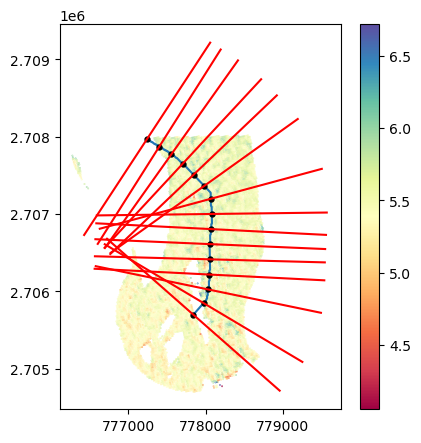

In [33]:

selCh = 2

# Select one channel
sel_channel = cl_gen.loc[cl_gen.branch_id == selCh]

# convert to UTM
centroid = sel_channel.geometry.unary_union.centroid
utm_zone = int((centroid.x + 180) // 6) + 1
if hemi == 'north':
    utm_crs = f'EPSG:{32600 + utm_zone}'
elif hemi == 'south':
    utm_crs = f'EPSG:{32700 + utm_zone}'
else:
    raise ValueError("Invalid hemisphere. Use 'north' or 'south'.")

sel_channel_utm = sel_channel.to_crs(utm_crs)
coords_list = list(sel_channel_utm.geometry.iloc[0].coords)
x_coords = [x for x,y in coords_list]
y_coords = [y for x,y in coords_list]

# extract point locations every 100 m along the line
sel_channel_utm["point_list"] = sel_channel_utm.apply(lambda x: create_points(row=x, point_separation=200), axis=1)

#Create a point dataframe by exploding the point list into individual points/rows
points_df = sel_channel_utm.explode(column="point_list")
points_df = points_df.set_geometry("point_list").drop(columns="geometry").rename_geometry("geometry").set_crs(sel_channel_utm.crs)

# Plot selected channel centerline and extracted points
ax = sel_channel_utm.plot(figsize=(5,5))
points_df.plot(ax=ax, zorder=2, color="black", markersize=50, marker=".")
points_df = points_df.reset_index(drop=True)

# Select SWOT data in this channel and transform to UTM
sub_swot = trimmed_gdf.loc[trimmed_gdf.channelID == selCh]
sub_swot_utm = sub_swot.to_crs(utm_crs)

theta = np.radians(90)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c))) #2D rotation matrix

print('points_df:',points_df)

for idx in points_df.index:
    coord = list(points_df.geometry.iloc[idx].coords)
    if idx == 0:
        coord_b4 = coord
        coord_af = list(points_df.geometry.iloc[idx+1].coords)

    if idx == len(points_df.index) - 1:
        coord_b4 = list(points_df.geometry.iloc[idx-1].coords)
        coord_af = coord


    if idx != len(points_df.index) - 1 and idx != 0:
        coord_b4 = list(points_df.geometry.iloc[idx-1].coords)
        coord_af = list(points_df.geometry.iloc[idx+1].coords)

    coord_b4 = [coord_b4[0][0],coord_b4[0][1]]
    coord_af = [coord_af[0][0],coord_af[0][1]]

    # Compute vector and rotated vector
    vec = calculate_vector_general(coord_b4,coord_af)
    rot_vec = np.dot(vec, R)

    pt1 = np.array(coord) - 1500*rot_vec
    pt2 = np.array(coord) + 1500*rot_vec
    line = LineString([Point(pt1),Point(pt2)])
    # plot transect
    temp_gdf_utm = gpd.GeoDataFrame(geometry=[line],crs=points_df.crs)
    temp_gdf_utm.plot(ax=ax, zorder=2, color="red")

    


    # 

sub_swot_utm.plot(ax=ax, column='heightEGM', markersize=0.1, legend=True,cmap='Spectral')

/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
/Users/sarahfranze/miniforge3/envs/swotPull/lib/python3.9/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
/var/folders/z8/rwrj_7dn6nv6_d2803hqbzc00000gn/T/ipykernel_88260/1601205854.py:43: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  subset.plot(ax=ax,column='heightEGM',

median H: nan


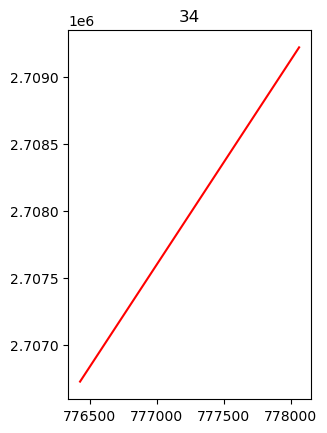

In [ ]:
from shapely.geometry import MultiPoint, shape
import shapely


ratioval = 0.01
if float(sel_channel_utm.geometry.length) > 3000:
    ratioval = 0.05

# Give each PIXC cloud point a point geometry
mpt = MultiPoint([shape(row['geometry']) for _, row in sub_swot_utm.iterrows()])
shapeout = shapely.concave_hull(mpt, ratio=ratioval,allow_holes=True)

#swot_boundary = gpd.GeoDataFrame(geometry=[mpt.convex_hull],crs=utm_crs)
swot_boundary = gpd.GeoDataFrame(geometry=[shapeout],crs=utm_crs)

ax = swot_boundary.plot()
temp_gdf_utm.plot(ax=ax, zorder=2, color="red")


inter_geom = shapely.intersection(swot_boundary,temp_gdf_utm)
inter_geom.plot(ax=ax, zorder=2, color="yellow")
inter_geom['width']=inter_geom.geometry.length

# maxwidth = float(0)
# linelist = list(inter_geom.geometry[0].geoms)

# for line in linelist:

#     if line.length > maxwidth:
#         maxwidth = line.length
#         line_centroid = shapely.centroid(line) 
#         print(line_centroid)
#         print(type(line_centroid))

extract_poly = inter_geom.geometry.iloc[0].buffer(100,cap_style="flat")
extract_poly_gdf = gpd.GeoDataFrame(geometry=[extract_poly],crs=utm_crs)
extract_poly_gdf.plot(ax=ax, zorder=2,color='green')
extract_poly_gdf

sub_swot_utm['inPoly']=extract_poly_gdf.geometry.iloc[0].contains(sub_swot_utm.geometry)
subset = sub_swot_utm[sub_swot_utm['inPoly']==True]

subset.plot(ax=ax,column='heightEGM',cmap='Spectral',markersize=0.1, legend=True)
medH = np.median(subset.heightEGM)
print('median H:',medH)

In [35]:
sel_channel_utm.geometry.length

1    2805.931937
dtype: float64

In [ ]:
sub_swot_utm['inPoly']=extract_poly_gdf.geometry.iloc[0].contains(sub_swot_utm.geometry)
subset = sub_swot_utm[sub_swot_utm['inPoly']==True]


height  heightEGM      geoid        lat        lon  class  \
172913 -49.523846   4.831287 -54.355133  24.287744  89.777626    4.0   
172914 -49.462612   4.892342 -54.354954  24.287769  89.777784    4.0   
172915 -49.607754   4.747391 -54.355145  24.287910  89.777422    4.0   
172916 -49.615818   4.739162 -54.354980  24.287933  89.777567    4.0   
173140 -49.506809   4.848305 -54.355114  24.288082  89.777254    4.0   
...           ...        ...        ...        ...        ...    ...   
177259 -49.515995   4.836910 -54.352905  24.289564  89.777846    4.0   
177260 -49.580826   4.771927 -54.352753  24.289585  89.777979    4.0   
177261 -49.682755   4.669853 -54.352608  24.289605  89.778106    4.0   
177263 -49.367615   4.985085 -54.352699  24.289761  89.777834    4.0   
177264 -49.347855   5.004673 -54.352528  24.289784  89.777984    4.0   

        water_frac  phase_noise_std  dheight_dphase        sig0  water_masked  \
172913    0.610904         0.026687       -5.890255   36.334000          True   
172914    0.711433         0.023711       -5.892725   44.368656          True   
172915    0.397202         0.023143       -5.887644   31.661026          True   
172916    0.932800         0.025345       -5.889903   55.763004          True   
173140    0.752379         0.021257       -5.885592   71.971901          True   
...            ...              ...             ...         ...           ...   
177259    0.943668         0.022171       -5.898748   85.440903          True   
177260    1.017719         0.023711       -5.900830   81.854996          True   
177261    0.451142         0.019316       -5.902800   51.586452          True   
177263    0.517625         0.021708       -5.899126   46.712505          True   
177264    1.263608         0.021481       -5.901465  100.168114          True   

               dist  channelID                        geometry  inPoly  
172913  6764.300800         12  POINT (781957.175 2688897.013)    True  
172914  6917.654444         12  POINT (781973.219 2688900.099)    True  
172915  6904.334721         12  POINT (781936.104 2688915.032)    True  
172916  6916.155640         12  POINT (781950.785 2688917.856)    True  
173140  6906.865547         12  POINT (781918.680 2688933.748)    True  
...             ...        ...                             ...     ...  
177259  7068.550270         12  POINT (781975.484 2689099.173)    True  
177260  7079.447270         12  POINT (781989.016 2689101.777)    True  
177261  7089.750538         12  POINT (782001.812 2689104.239)    True  
177263  7083.792026         12  POINT (781973.842 2689120.928)    True  
177264  7096.031568         12  POINT (781989.043 2689123.853)    True  

[856 rows x 15 columns]

In [ ]:
# Also save the median height value within a 50 m radius (100 m diameter) of the centroid of the largest line piece